In [119]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import control as ct
from pytz import timezone

import sys
sys.path.append('../../../')

from utils.plot import config_matplotlib, figsize, fig_save_and_show, plot_events_data, plot_efficiency_map_scattered
from utils.optimization import MyOptimizationProblem, convert_to_model_params, plot_optimization_params, plot_optimization_error, plot_compare, compute_metrics
from utils.data import get_events, get_sections, load_df, process_df, export_dataframe_to_latex
from utils.sensitivity_analysis import describe_param_with_uniform_distribution, describe_param_with_log_uniform_distribution, describe_param_with_triangular_distribution, describe_param_with_normal_distribution, describe_param_with_truncated_normal_distribution, describe_param_with_log_normal_distribution, wrapped_model_function, create_problem_spec_and_sample, plot_sampled_distribuitions, evaluate_problem, analyze_time_step, analyze_problem, sobol_sensitivity_analysis_from_model_params_to_outputs, plot_sensitivity_analysis, plot_sensitivity_analysis_heatmaps, get_region_mean, plot_sensitivity_analysis_bars
from utils.control import step_response, plot_step_response_dataframe, get_steady_state_map

import warnings
warnings.filterwarnings("ignore")

config_matplotlib()
latex_img_path = '/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs/'
latex_tex_path = '/home/joaoantoniocardoso/workspace_TCC/repo/tcc/tex/'

# Data

In [120]:
def read_oscilloscope_csv_old(file_name: str, type: str = "tek_tds1012") -> list:
    import csv

    if type == "tek_tds1012":
        raw_x = []
        raw_y = []

        with open(file_name, "r") as csv_file:
            c = csv.reader(csv_file)

            in_header = True
            for row in c:
                if in_header:
                    if row[0] == "Record Length":
                        record_length = float(row[1])
                    if row[0] == "Sample Interval":
                        sample_interval = float(row[1])
                    if row[0] == "Source":
                        source = str(row[1])
                    if row[0] == "Vertical Units":
                        vertical_units = str(row[1])
                    if row[0] == "Vertical Scale":
                        vertical_scale = float(row[1])
                    if row[0] == "Vertical Offset":
                        vertical_offset = float(row[1])
                    if row[0] == "Horizontal Units":
                        horizontal_units = str(row[1])
                    if row[0] == "Horizontal Scale":
                        horizontal_scale = float(row[1])
                    if row[0] == "Pt Fmt":
                        pt_fmt = str(row[1])
                    if row[0] == "Yzero":
                        yzero = float(row[1])
                    if row[0] == "Probe Atten":
                        probe_atten = float(row[1])
                    if row[0] == "Model Number":
                        model_number = str(row[1])
                    if row[0] == "Serial Number":
                        serial_number = str(row[1])
                    if row[0] == "Firmware Version":
                        firmware_version = str(row[1])
                        in_header = False
                else:
                    raw_x.append(float(row[3]))
                    raw_y.append(float(row[4]))

            info_dict = {
                "Record Length": record_length,
                "Sample Interval": sample_interval,
                "Source": source,
                "Vertical Units": vertical_units,
                "Vertical Scale": vertical_scale,
                "Vertical Offset": vertical_offset,
                "Horizontal Units": horizontal_units,
                "Horizontal Scale": horizontal_scale,
                "Pt Fmt": pt_fmt,
                "Yzero": yzero,
                "Probe Atten": probe_atten,
                "Model Number": model_number,
                "Serial Number": serial_number,
                "Firmware Version": firmware_version,
            }

        return np.array(raw_x), np.array(raw_y), info_dict


def read_oscilloscope_csv(file_name: str) -> tuple:
    import csv

    with open(file_name, "r") as csv_file:
        c = csv.reader(csv_file)

        raw_x = []
        raw_y_CH1 = []
        raw_y_CH2 = []
        raw_y_CH3 = []
        raw_y_CH4 = []
        probe_atten = [0, 0, 0, 0]
        vertical_units = ["", "", "", ""]
        vertical_offset = [0, 0, 0, 0]
        vertical_scale = [0, 0, 0, 0]

        in_header = True
        for row in c:
            if row:
                if in_header:
                    if row is []:
                        pass
                    elif "Model" in row[0]:
                        model_number = str(row[1])
                    elif "Firmware Version" in row[0]:
                        firmware_version = str(row[1])
                    elif "Horizontal Unit" in row[0]:
                        horizontal_units = str(row[1])
                    elif "Horizontal Scale" in row[0]:
                        horizontal_scale = float(row[1])
                    elif "Sample Interval" in row[0]:
                        sample_interval = float(row[1])
                    elif "Filter Frequency" in row[0]:
                        sample_interval = float(row[1])
                    elif "Record Length" in row[0]:
                        record_length = float(row[1])
                    elif "Probe Attenuation" in row[0]:
                        probe_atten[0] = float(row[1])
                        probe_atten[1] = float(row[2])
                        probe_atten[2] = float(row[3])
                    elif "Vertical Units" in row[0]:
                        vertical_units[0] = str(row[1])
                        vertical_units[1] = str(row[2])
                        vertical_units[2] = str(row[3])
                    elif "Vertical Offset" in row[0]:
                        vertical_offset[0] = float(row[1])
                        vertical_offset[1] = float(row[2])
                        vertical_offset[2] = float(row[3])
                    elif "Vertical Scale" in row[0]:
                        vertical_scale[0] = float(row[1])
                        vertical_scale[1] = float(row[2])
                        vertical_scale[2] = float(row[3])
                    elif row[0] == "Label":
                        pass
                    elif row[0] == "TIME":
                        in_header = False
                else:
                    raw_x.append(float(row[0]))
                    raw_y_CH1.append(float(row[1]))
                    raw_y_CH2.append(float(row[2]))
                    raw_y_CH3.append(float(row[3]))
                    raw_y_CH4.append(float(row[4]))

        info_dict = {
            "Record Length": record_length,
            "Sample Interval": sample_interval,
            "Vertical Units": vertical_units,
            "Vertical Scale": vertical_scale,
            "Vertical Offset": vertical_offset,
            "Horizontal Units": horizontal_units,
            "Horizontal Scale": horizontal_scale,
            "Probe Atten": probe_atten,
            "Firmware Version": firmware_version,
        }

        ret = (
            np.array(raw_x),
            np.array(raw_y_CH1),
            np.array(raw_y_CH2),
            np.array(raw_y_CH3),
            np.array(raw_y_CH4),
            info_dict,
        )

        return ret


def read_oscilloscope_csv_other(file_name: str) -> list:
    import csv

    with open(file_name, "r") as csv_file:
        c = csv.reader(csv_file)

        index_CH1 = 1
        index_CH2 = 3
        index_CH3 = 5

        raw_x = []
        raw_y_CH1 = []
        raw_y_CH2 = []
        raw_y_CH3 = []
        probe_atten = [0, 0, 0]
        vertical_units = ["", "", ""]
        vertical_offset = [0, 0, 0]
        vertical_scale = [0, 0, 0]

        in_header = True
        for row in c:
            if row:
                if in_header:
                    if row is []:
                        pass
                    if row[0] == "Model":
                        model_number = str(row[1])
                    if row[0] == "Firmware Version":
                        firmware_version = str(row[1])
                    if row[0] == "Horizontal Units":
                        horizontal_units = str(row[1])
                    if row[0] == "Horizontal Scale":
                        horizontal_scale = float(row[1])
                    if row[0] == "Sample Interval":
                        sample_interval = float(row[1])
                    if row[0] == "Filter Frequency":
                        sample_interval = float(row[1])
                    if row[0] == "Record Length":
                        record_length = float(row[1])
                    if row[0] == "Probe Attenuation":
                        probe_atten[0] = float(row[index_CH1])
                        probe_atten[1] = float(row[index_CH2])
                        probe_atten[2] = float(row[index_CH3])
                    if row[0] == "Vertical Units":
                        vertical_units[0] = str(row[index_CH1])
                        vertical_units[1] = str(row[index_CH2])
                        vertical_units[2] = str(row[index_CH3])
                    if row[0] == "Vertical Offset":
                        vertical_offset[0] = float(row[index_CH1])
                        vertical_offset[1] = float(row[index_CH2])
                        vertical_offset[2] = float(row[index_CH3])
                    if row[0] == "Vertical Scale":
                        vertical_scale[0] = float(row[index_CH1])
                        vertical_scale[1] = float(row[index_CH2])
                        vertical_scale[2] = float(row[index_CH3])
                    if row[0] == "Label":
                        pass
                    if row[0] == "TIME":
                        in_header = False
                else:
                    raw_x.append(float(row[0]))
                    raw_y_CH1.append(float(row[index_CH1]))
                    raw_y_CH2.append(float(row[index_CH2]))
                    raw_y_CH3.append(float(row[index_CH3]))

        info_dict = {
            "Record Length": record_length,
            "Sample Interval": sample_interval,
            "Vertical Units": vertical_units,
            "Vertical Scale": vertical_scale,
            "Vertical Offset": vertical_offset,
            "Horizontal Units": horizontal_units,
            "Horizontal Scale": horizontal_scale,
            "Probe Atten": probe_atten,
            "Firmware Version": firmware_version,
        }

        return (
            np.array(raw_x),
            np.array(raw_y_CH1),
            np.array(raw_y_CH2),
            np.array(raw_y_CH3),
            info_dict,
        )


In [121]:
def load_df(filename):
    time, xdata, ydata_p1, ydata_p2, info_dict = read_oscilloscope_csv_other(filename)
    ydata = ydata_p1 + ydata_p2
    del ydata_p1, ydata_p2

    time_len = len(time)
    time = np.linspace(0, (time[-1] - time[0])*1e9, time_len, dtype='timedelta64[ns]')

    df = pd.DataFrame()
    df['time'] = time
    df['motor_v'] = xdata
    df['motor_i'] = ydata
    df['motor_q_load'] = 0 # Free shaft
    df.set_index('time', inplace=True)

    df['t'] = time.astype(np.float64)*1e-9  # Simulation time in seconds as floats

    del time, xdata, ydata

    return df

filename = "data/motor_free_rotor_step.csv"
df = load_df(filename)[100000:]
display(df)

,motor_v,motor_i,motor_q_load,t
time,,,,
0 days 00:00:00.007999999,0.04,2.000000,0,0.008
0 days 00:00:00.008000079,0.04,1.999996,0,0.008
0 days 00:00:00.008000159,0.04,1.999996,0,0.008
0 days 00:00:00.008000239,0.04,-0.000003,0,0.008
0 days 00:00:00.008000319,0.04,3.999999,0,0.008
...,...,...,...,...
0 days 00:00:00.099999599,11.72,40.000000,0,0.100
0 days 00:00:00.099999679,11.80,40.000000,0,0.100
0 days 00:00:00.099999759,11.80,42.000000,0,0.100


In [122]:
original_period = df.index.diff().median().to_numpy()
print('Original period is:', original_period)

print('Last timestamp is:\n', df.iloc[-1])

Original period is: 80 nanoseconds
Last timestamp is:
 motor_v         11.8
motor_i         40.0
motor_q_load     0.0
t                0.1
Name: 0 days 00:00:00.099999919, dtype: float64


In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import decimate as decimate_inner
import multiprocessing

def decimate_column(col_name, data, factor):
    return col_name, decimate_inner(data, factor, ftype='fir', n=8, zero_phase=True)

def decimate(df, target_period, original_period):
    # Ensure the DataFrame is evenly spaced by interpolating
    df = df.resample(original_period).mean().interpolate(method='time', limit_area='inside', limit=100)

    # Calculate downsampling factor
    original_freq = pd.Timedelta(original_period).to_numpy().astype('timedelta64[ns]').astype('float')*1e-9
    target_freq = pd.Timedelta(target_period).to_numpy().astype('timedelta64[ns]').astype('float')*1e-9
    factor = int(target_freq / original_freq)

    # Select numerical columns to process
    numerical_columns = df.select_dtypes(include=[np.number]).columns
    column_data = [(col_name, df[col_name].values, factor) for col_name in numerical_columns]

    # Process columns in parallel using apply_async
    with multiprocessing.Pool(processes=multiprocessing.cpu_count()) as pool:
        results = [pool.apply_async(decimate_column, args=(col_name, data, factor)) for col_name, data, factor in column_data]

        # Collect results
        results_data = {}
        for r in results:
            col_name, decimated = r.get()
            results_data[col_name] = decimated

    # Combine results into a DataFrame
    downsampled_index = df.index[::factor]
    downsampled_df = pd.DataFrame(results_data, index=downsampled_index)

    # Fix the initial point
    downsampled_df.iloc[0] = df.iloc[0]

    # Recreate time
    T = (downsampled_df.index[1] - downsampled_df.index[0]).to_numpy().astype(np.float64) * 1e-9   # simulation time in seconds
    lenT = len(downsampled_df.index)
    downsampled_df['t'] = np.linspace(0, lenT * T, lenT, endpoint=False)  # Recreate the time array because of numerical issues from the index datetime to float transformation

    return downsampled_df

dfa = df.copy(deep=True)

df = decimate(df, target_period='0.1ms', original_period='80ns')
df

,motor_v,motor_i,motor_q_load,t
time,,,,
0 days 00:00:00.007999999,0.040000,2.000000,0.0,0.0000
0 days 00:00:00.008099999,0.030182,2.036359,0.0,0.0001
0 days 00:00:00.008199999,0.040000,1.411485,0.0,0.0002
0 days 00:00:00.008299999,0.040000,2.245454,0.0,0.0003
0 days 00:00:00.008399999,0.030182,1.018177,0.0,0.0004
...,...,...,...,...
0 days 00:00:00.099499999,11.812823,39.902396,0.0,0.0915
0 days 00:00:00.099599999,11.800000,40.111488,0.0,0.0916
0 days 00:00:00.099699999,11.800000,39.545453,0.0,0.0917


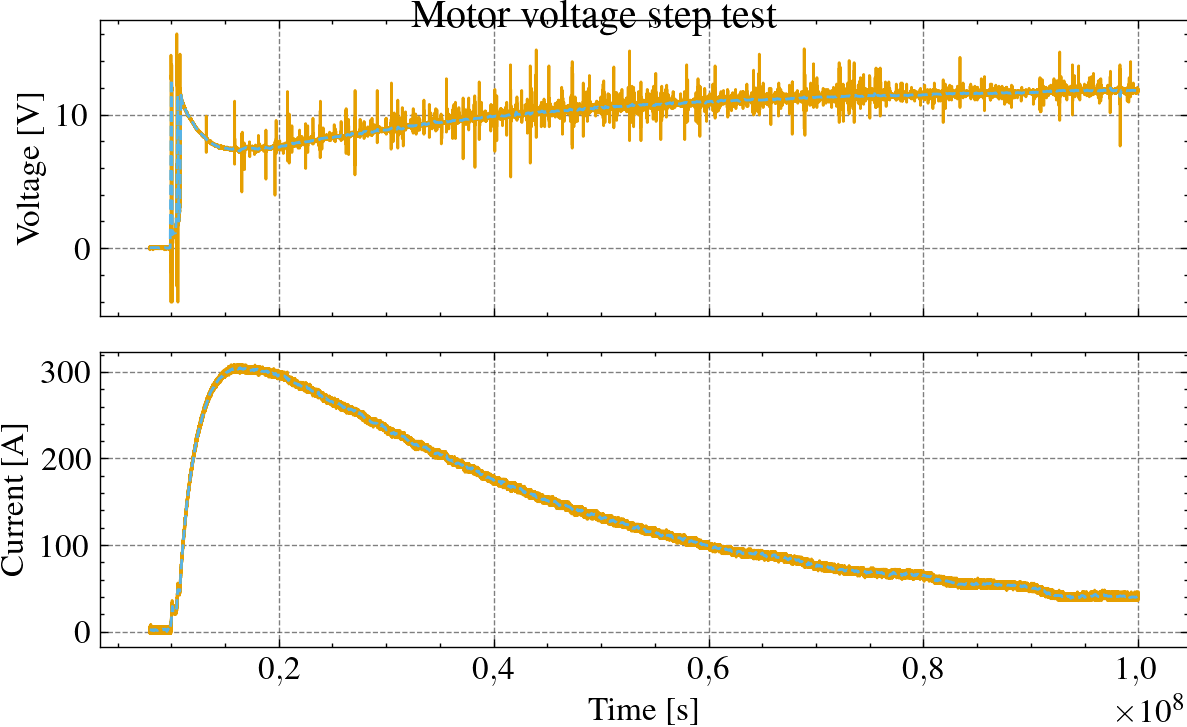

In [124]:
# Plot the original data and the fitted curve
title_en = 'Motor voltage step test'
title_ptg = 'Teste de degrau de tensão no motor'
filename = f'{latex_img_path}/motor_free_rotor_step_data.pdf'

fig, ax = plt.subplots(2, 1, sharex=True)

ax[0].plot(dfa.index, dfa['motor_v'], label=f'')
ax[0].plot(df.index, df['motor_v'], label=f'')
ax[0].set_ylabel('Voltage [V]')

ax[1].plot(dfa.index, dfa['motor_i'], label=f'Original')
ax[1].plot(df.index, df['motor_i'], label=f'Downsampled at 1ms')
ax[1].set_ylabel('Current [A]')

plt.xlabel('Time [s]')
plt.tight_layout()

fig_save_and_show(filename, title_ptg, title_en, ncol=2)

# Model

In [125]:
import control as ct

class Motor:
    @classmethod
    def initial_state(cls, X0: dict, U0, params: dict):
        # Params
        motor_R_A = params['motor_R_A']
        motor_B = params['motor_B']
        motor_K_Q = params['motor_K_Q']
        motor_K_V = params['motor_K_V']

        # Input Initial Conditions
        # ( None )

        # Inputs
        motor_v = U0[0]
        motor_q_load = U0[1]

        # Initial condition equations
        motor_i = (motor_B*motor_v + motor_K_V*motor_q_load)/(motor_B*motor_R_A + motor_K_Q*motor_K_V)
        motor_w = (motor_K_Q*motor_v - motor_R_A*motor_q_load)/(motor_B*motor_R_A + motor_K_Q*motor_K_V)

        return np.array([motor_i, motor_w])

    @classmethod
    def _update(cls, t, x, u, params: dict):
        # Params
        motor_R_A = params['motor_R_A']
        motor_L_A = params['motor_L_A']
        motor_B = params['motor_B']
        motor_I_r = params['motor_I_r']
        motor_I_r_load = params['motor_I_r_load']
        motor_K_Q = params['motor_K_Q']
        motor_K_V = params['motor_K_V']

        # States
        motor_i = x[0]  # Motor current [A]
        motor_w = x[1]  # Motor angular speed [rad/s]

        # Inputs
        motor_v = u[0]
        motor_q_load = u[1]

        # System of differential equations
        d_motor_i = (-motor_K_V*motor_w - motor_R_A*motor_i + motor_v)/motor_L_A
        d_motor_w = (-motor_B*motor_w + motor_K_Q*motor_i - motor_q_load)/(motor_I_r + motor_I_r_load)

        return np.array([d_motor_i, d_motor_w])

    @classmethod
    def build(cls, params: dict):
        return ct.NonlinearIOSystem(
            cls._update,
            None,
            name='motor',
            states=('motor_i', 'motor_w'),
            inputs=('motor_v', 'motor_q_load'),
            outputs=('motor_i', 'motor_w'),
            params=params,
        )

Motor.build({})

<NonlinearIOSystem motor: ['motor_v', 'motor_q_load'] -> ['motor_i', 'motor_w']>

In [126]:
Motor.build({}).input_index

{'motor_v': 0, 'motor_q_load': 1}

In [127]:
motor_params = {
    # From models/2020/Motor/me0909_steady_state.ipynb - steady-state model fitted to manufacturer's dataset
    'motor_R_A': 0.03211280350781205,
    'motor_B': 0.0012793008044770459,
    'motor_K_Q': 0.10543193741528227,
    'motor_K_V': 0.10337093946599393,
    # Randomly chosen:
    'motor_L_A': 50e-06,
    'motor_I_r': 1e-2,
    'motor_I_r_load': 0,
}

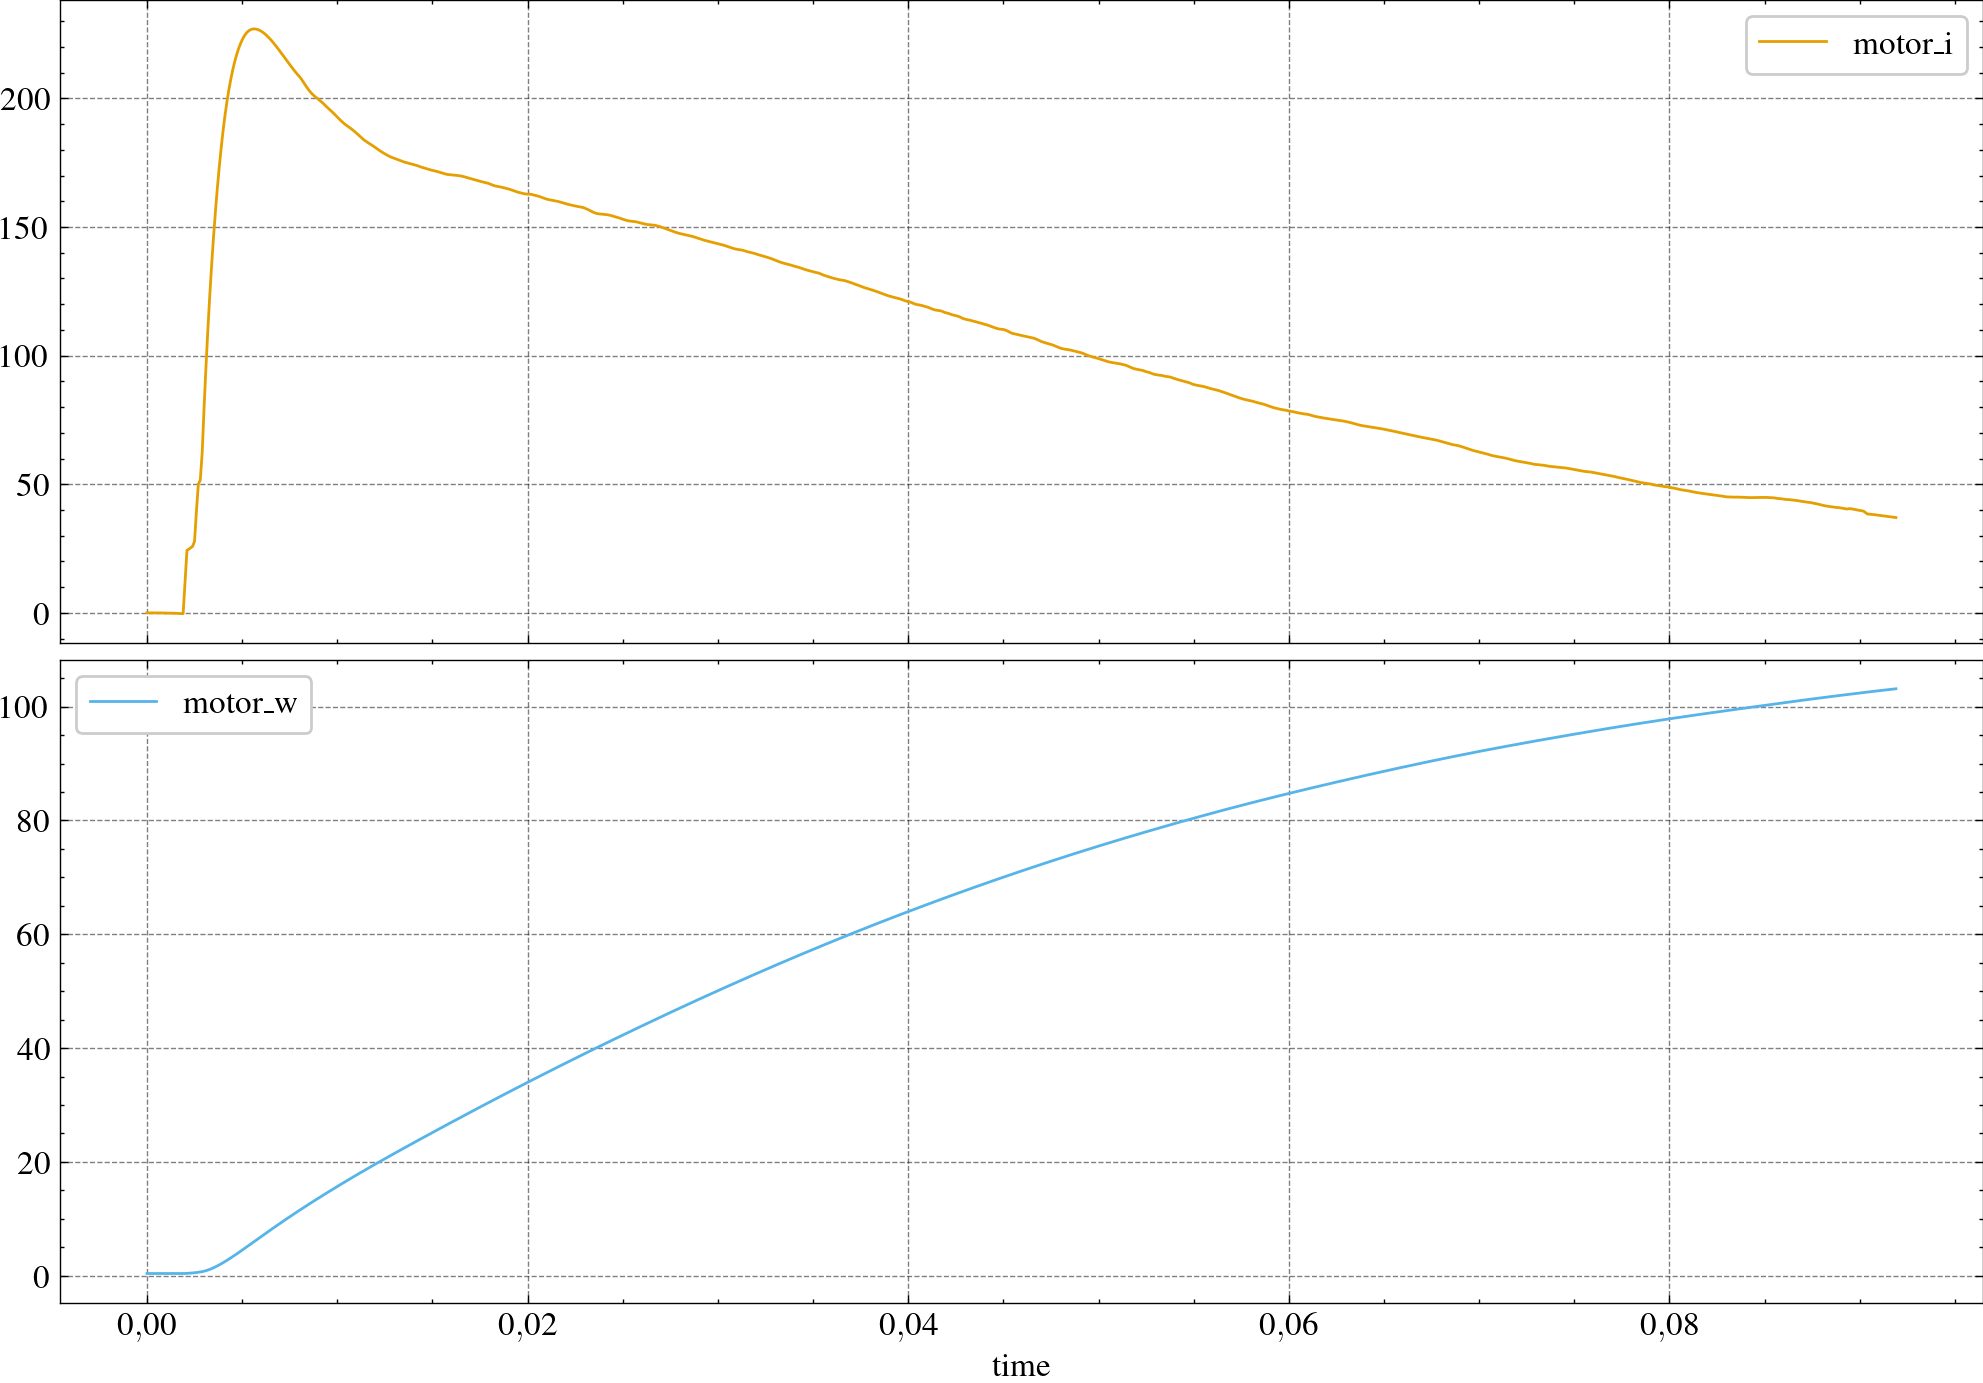

In [128]:
# Time array
T = df['t'].to_numpy()

# Inputs
U = df[['motor_v', 'motor_q_load']].to_numpy().T

# Model
motor = Motor.build(motor_params)

# Initial state
X0 = Motor.initial_state(X0={}, U0=U[:,0], params=motor_params)

# Simulation
res = ct.input_output_response(motor, T=T, U=U, X0=X0, solve_ivp_method='Radau')
ydata = res.to_pandas().set_index('time')[res.output_labels]

ydata.plot(subplots=True, figsize=(10,7));
plt.show()

motor_i   motor_w
trace_label       time                        
From motor_v      0.0000    0.004678  0.385502
                  0.0001   69.661260  0.422615
                  0.0002  134.970097  0.530852
                  0.0003  196.187671  0.705767
From motor_q_load 0.0000    0.004678  0.385502
                  0.0001   -0.062685  0.285465
                  0.0002   -0.105821  0.185371
                  0.0003   -0.126225  0.085245

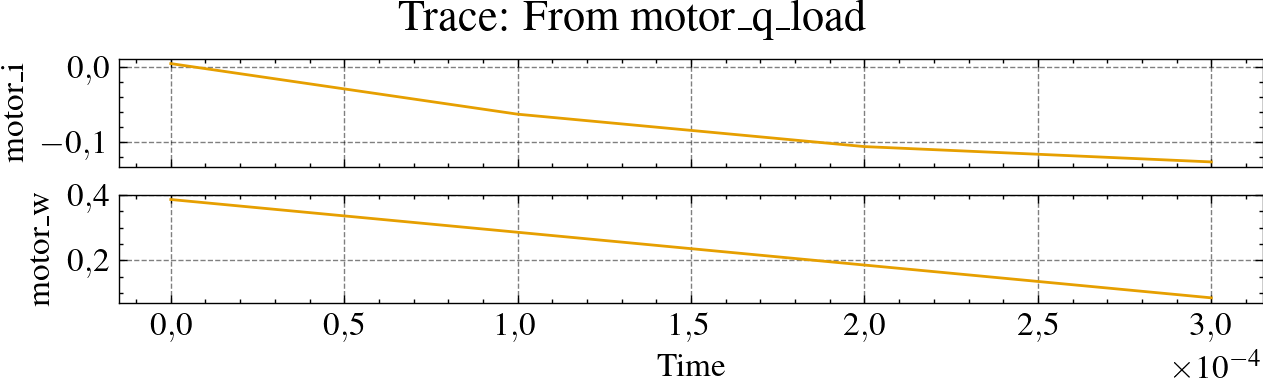

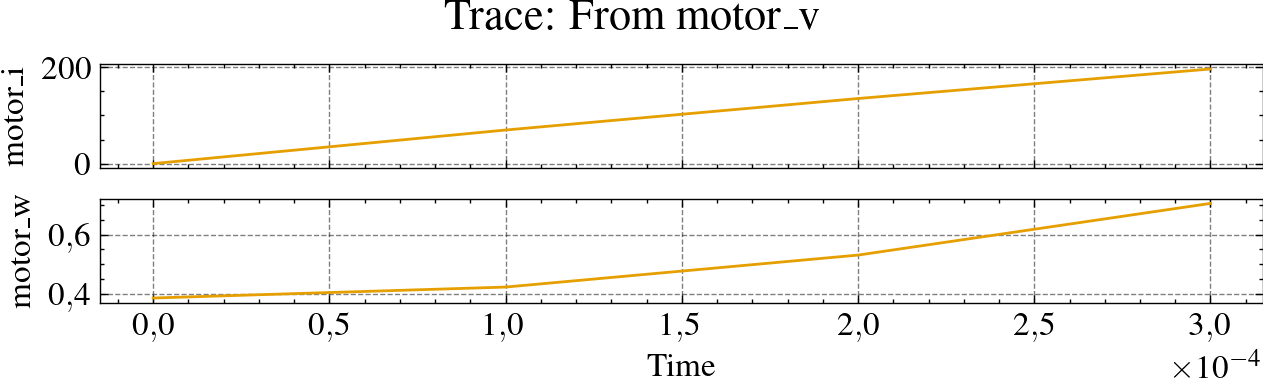

In [129]:
# Model
motor = Motor.build(motor_params)

# Time array
T = df['t'].to_numpy()[:4]

# Initial state
X0 = Motor.initial_state(X0={}, U0=U[:,0], params=motor_params)

step_values = {
    'motor_v': 36,
    'motor_q_load': 10,
}

res = step_response(motor, T=T, X0=X0, input_values=step_values, solve_ivp_method='Radau').set_index(['trace_label', 'time'])[motor.output_labels]
display(res)

plot_step_response_dataframe(res)


# Sensitivity Analysis

In [130]:
def model_function(T, U, X0, **params):
    return ct.input_output_response(
        Motor.build(params=params),
        T=T,
        U=U,
        X0=X0,
        solve_ivp_method='Radau',
    ).to_pandas()

def motor_sensitivity_analysis_step_response(
    params_description: dict,
    voltage_step: float,
    motor_load_torque_step: float,
    samples: int,
    do_plot=True,
):

    model_class = Motor
    model_params = motor_params
    model_tmp = model_class.build(model_params)

    # Time array
    T = np.linspace(0, 0.1, 11, endpoint=True)

    # Input data
    U = np.empty([model_tmp.ninputs, len(T)]) * np.nan # nan to force us to define every input
    U[model_tmp.input_labels.index('motor_v')] = voltage_step
    U[model_tmp.input_labels.index('motor_q_load')] = motor_load_torque_step

    # Initial state
    X0 = Motor.initial_state(X0={}, U0=U[:,0], params=motor_params)

    df_sa, problem = sobol_sensitivity_analysis_from_model_params_to_outputs(
        params_description=params_description,
        T=T,
        U=U,
        X0=X0,
        model_function=model_function,
        model_class=model_class,
        model_params=model_params,
        samples=samples,
        calc_second_order=False,
        seed=42,
        nprocs=32,
    )

    df_steady_state_mean = get_region_mean(df_sa, t_start=0.09, t_end=0.1)

    export_dataframe_to_latex(
        filename=f"{latex_tex_path}/motor_sensitivity_analysis_{voltage_step}_{motor_load_torque_step}.tex",
        label=f'table:motor_sensitivity_analysis_{voltage_step}_{motor_load_torque_step}',
        caption='Índices de Sobol em regime permanente',
        df_steady_state_mean=df_steady_state_mean,
    )

    if do_plot:
        display(df_steady_state_mean)

        fig_save_and_show(
            filename=f"{latex_img_path}/motor_sensitivity_analysis_distributions.pdf",
            save_title='Distribuição dos valores para cada fator',
            show_title='Distribution of the values for each factor',
            fig=plot_sampled_distribuitions(problem),
            ncols=3,
        )

        for output in df_sa['output'].unique():
            fig_save_and_show(
                filename=f"{latex_img_path}/motor_sensitivity_analysis_{voltage_step}_{motor_load_torque_step}_{output}.pdf",
                save_title=f'Índices de Sobol para a saída {output} durante o tempo,\ncom degrau de {voltage_step} [V] e {motor_load_torque_step} [Nm],\ncom {samples} amostras',
                show_title=f'Sobol Indices for the output {output} over time\nwith step of {voltage_step} [V] and {motor_load_torque_step} [Nm],\nwith {samples} samples',
                fig=plot_sensitivity_analysis(df_sa, output=output),
                ncols=3,
            )

        for output in df_sa['output'].unique():
            fig_save_and_show(
                filename=f"{latex_img_path}/motor_sensitivity_analysis_heatmaps_{voltage_step}_{motor_load_torque_step}_{output}.pdf",
                save_title=f'Índices de Sobol para a saída {output} durante o tempo,\ncom degrau de {voltage_step} [V] e {motor_load_torque_step} [Nm],\ncom {samples} amostras',
                show_title=f'Sobol Indices for the output {output} over time\nwith step of {voltage_step} [V] and {motor_load_torque_step} [Nm],\nwith {samples} samples',
                fig=plot_sensitivity_analysis_heatmaps(df_sa, output=output),
                ncols=3,
            )

        for output in df_sa['output'].unique():
            fig_save_and_show(
                filename=f"{latex_img_path}/motor_sensitivity_analysis_bars_{voltage_step}_{motor_load_torque_step}_{output}.pdf",
                save_title=f'Índices de Sobol para a saída {output} em regime permanente,\ncom degrau de {voltage_step} [V] e {motor_load_torque_step} [Nm],\ncom {samples} amostras',
                show_title=f'Sobol Indices for the output {output} at steady-state\nwith step of {voltage_step} [V] and {motor_load_torque_step} [Nm],\nwith {samples} samples',
                fig=plot_sensitivity_analysis_bars(df_steady_state_mean, output=output),
                ncols=3,
            )

    return df_sa, problem


In [131]:
# Setting all uncertainties to be x%
u_motor_R_A = 1/100
u_motor_B = 1/100
u_motor_K_Q = 1/100
u_motor_K_V = 1/100
u_motor_L_A = 1/100
u_motor_I_r = 1/100
u_motor_I_r_load = 1/100

pool
chain


value          conf
output  factor    metric                            
motor_i motor_R_A S1      1.384679e-05  1.504425e-04
                  ST      1.889677e-04  2.932773e-06
        motor_L_A S1      5.386425e-08  4.533141e-06
                  ST      1.851729e-07  2.353711e-09
        motor_K_V S1      9.822711e-01  9.151850e-03
                  ST      9.831220e-01  6.412022e-03
        motor_K_Q S1      8.456589e-03  1.011137e-03
                  ST      8.800904e-03  9.993315e-05
        motor_I_r S1     -1.844170e-07  2.073897e-04
                  ST      3.302931e-04  4.097512e-06
        motor_B   S1      8.409236e-03  9.381783e-04
                  ST      8.409655e-03  9.046871e-05
motor_w motor_R_A S1      1.428117e-05  4.025455e-05
                  ST      1.499198e-05  1.896039e-07
        motor_L_A S1     -8.370947e-10  3.158879e-07
                  ST      9.192189e-10  1.155816e-11
        motor_K_V S1      9.999551e-01  9.139126e-03
                  ST      9.999570e-01  6.346900e-03
        motor_K_Q S1      1.435888e-05  4.289917e-05
                  ST      1.500111e-05  1.741083e-07
        motor_I_r S1      7.460670e-09  8.406754e-06
                  ST      5.628679e-07  6.952630e-09
        motor_B   S1      1.426569e-05  3.921319e-05
                  ST      1.426985e-05  1.559198e-07

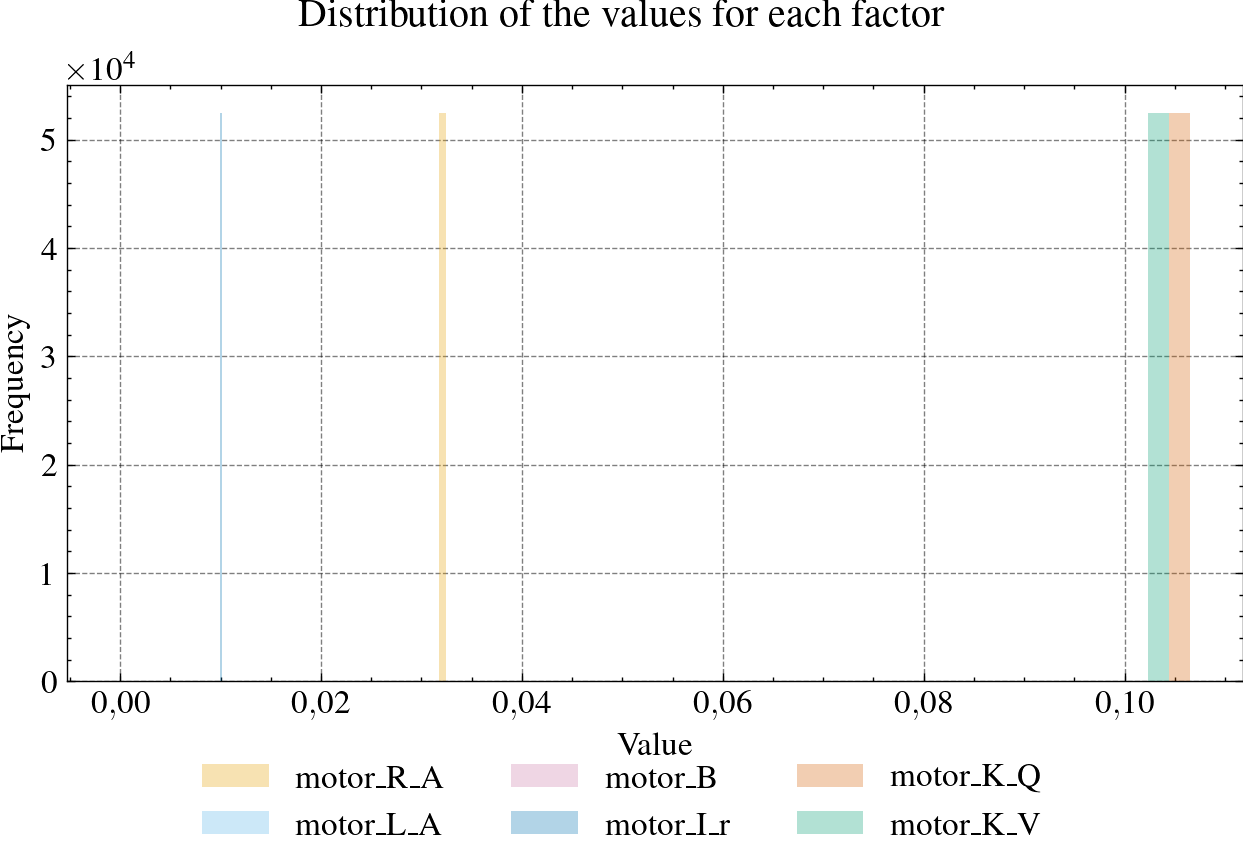

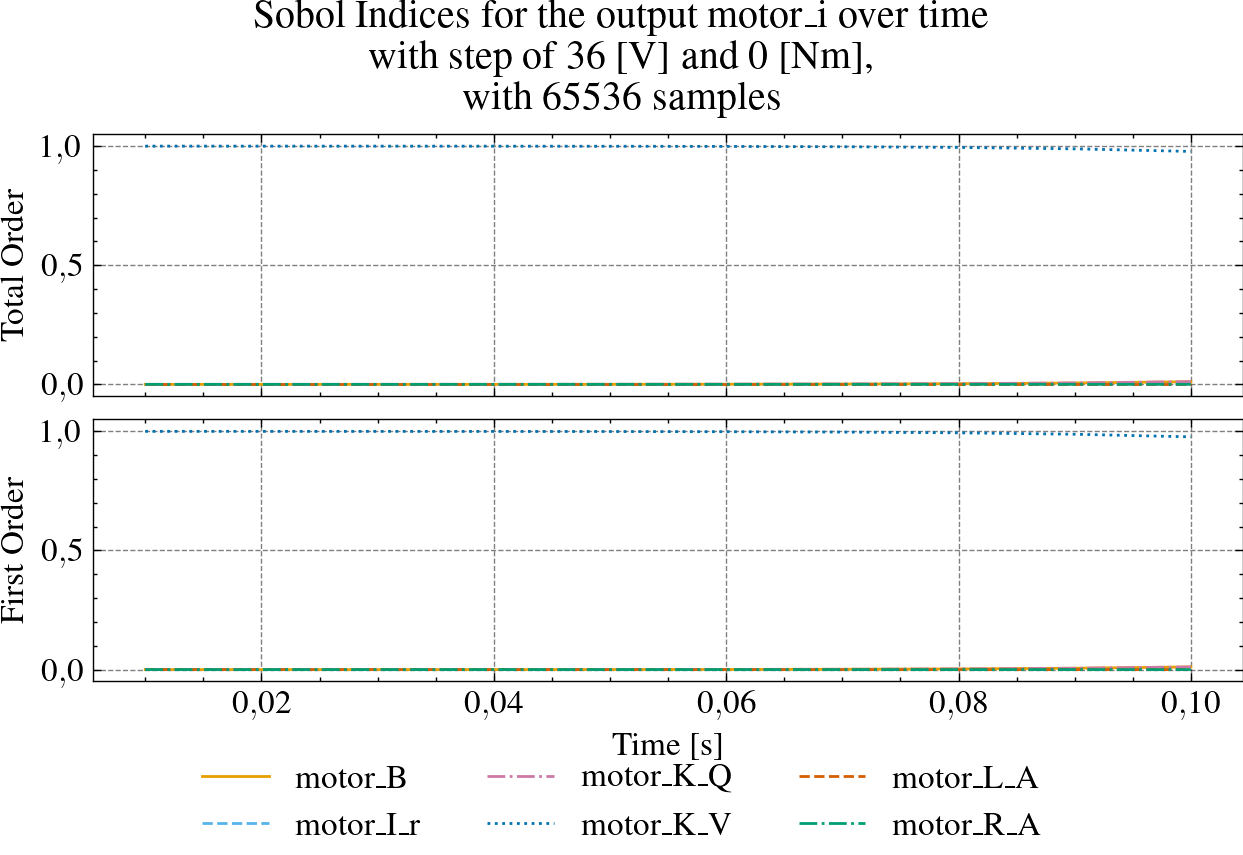

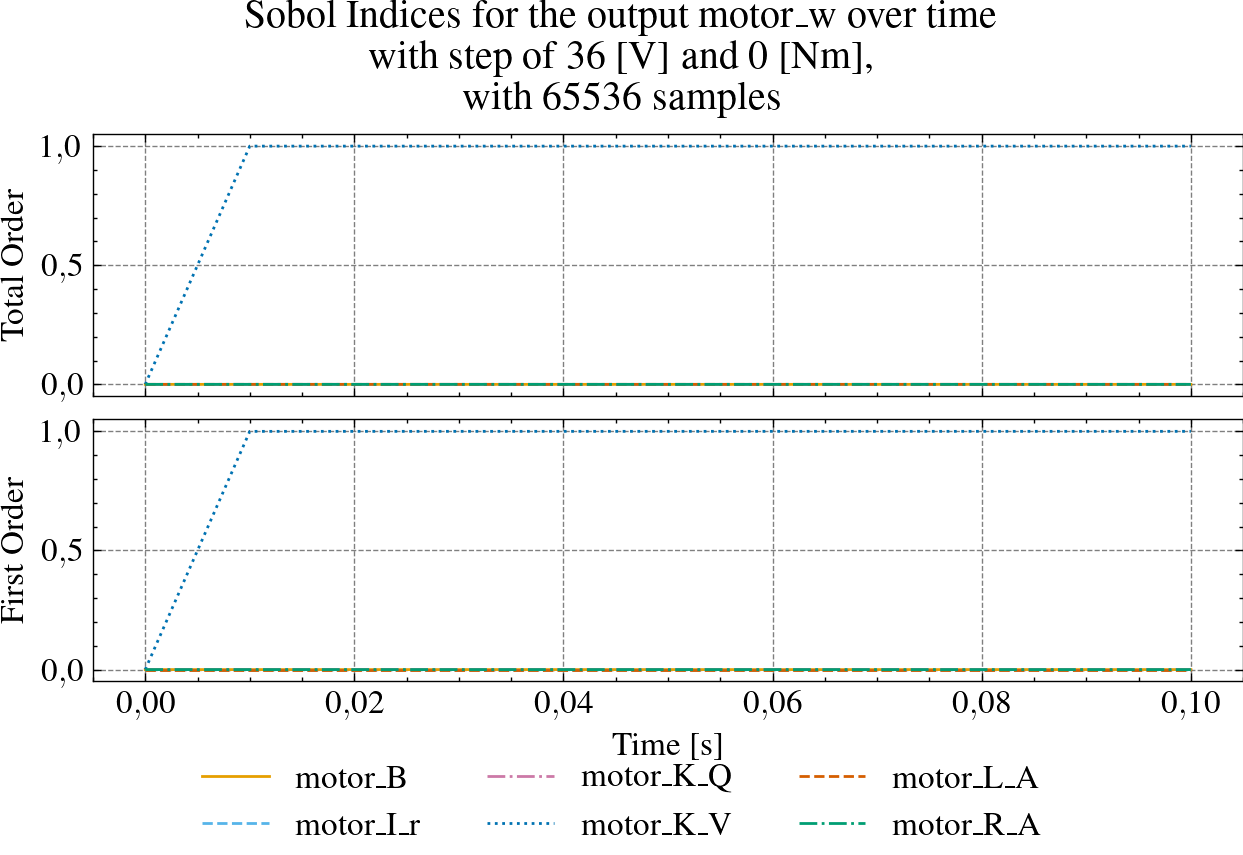

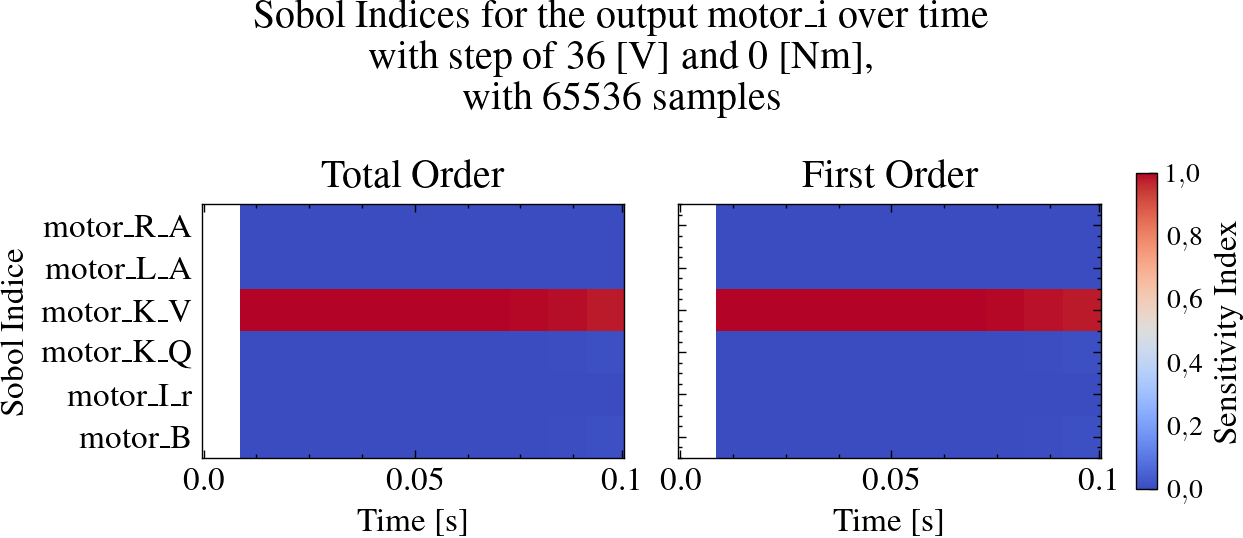

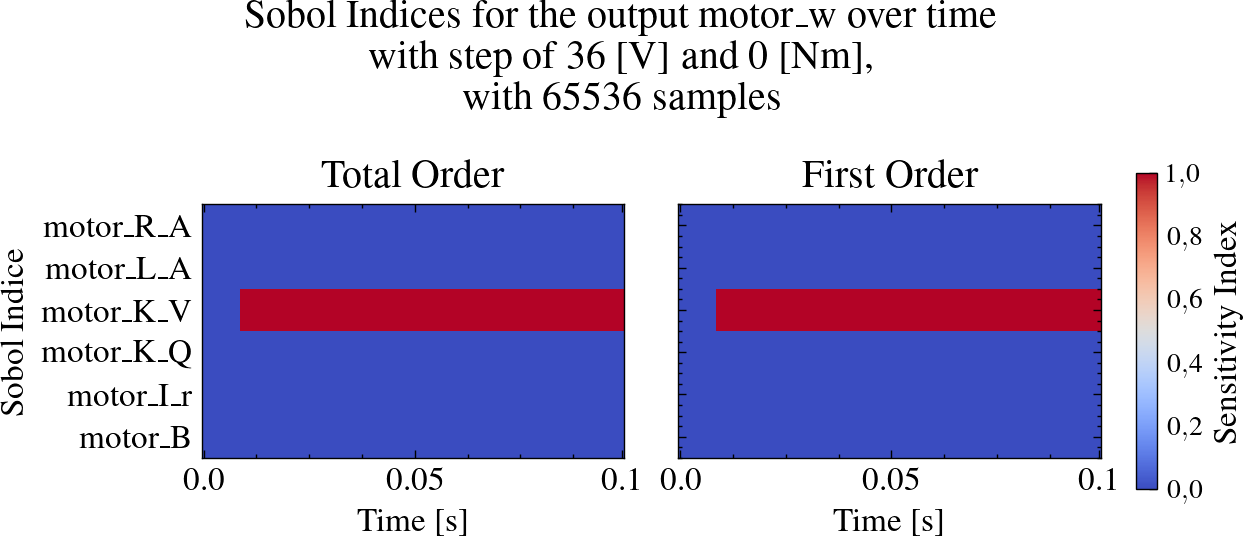

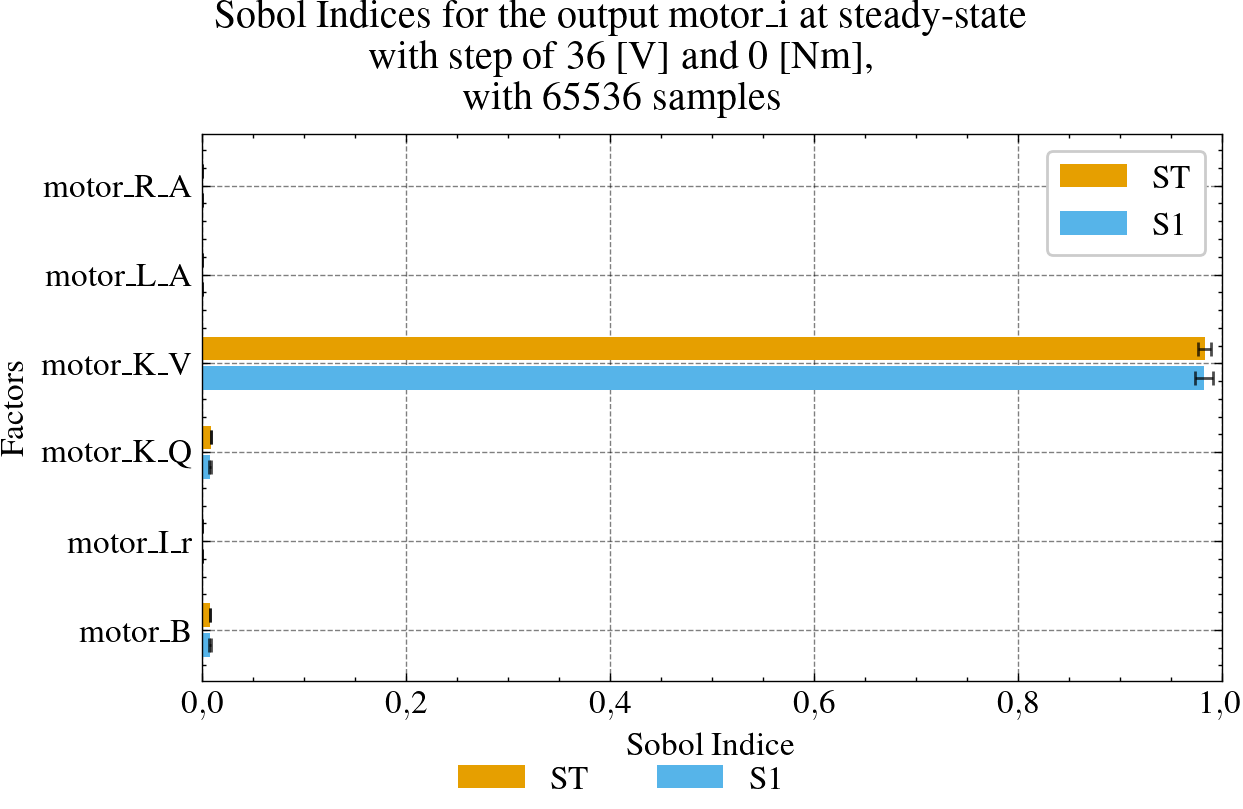

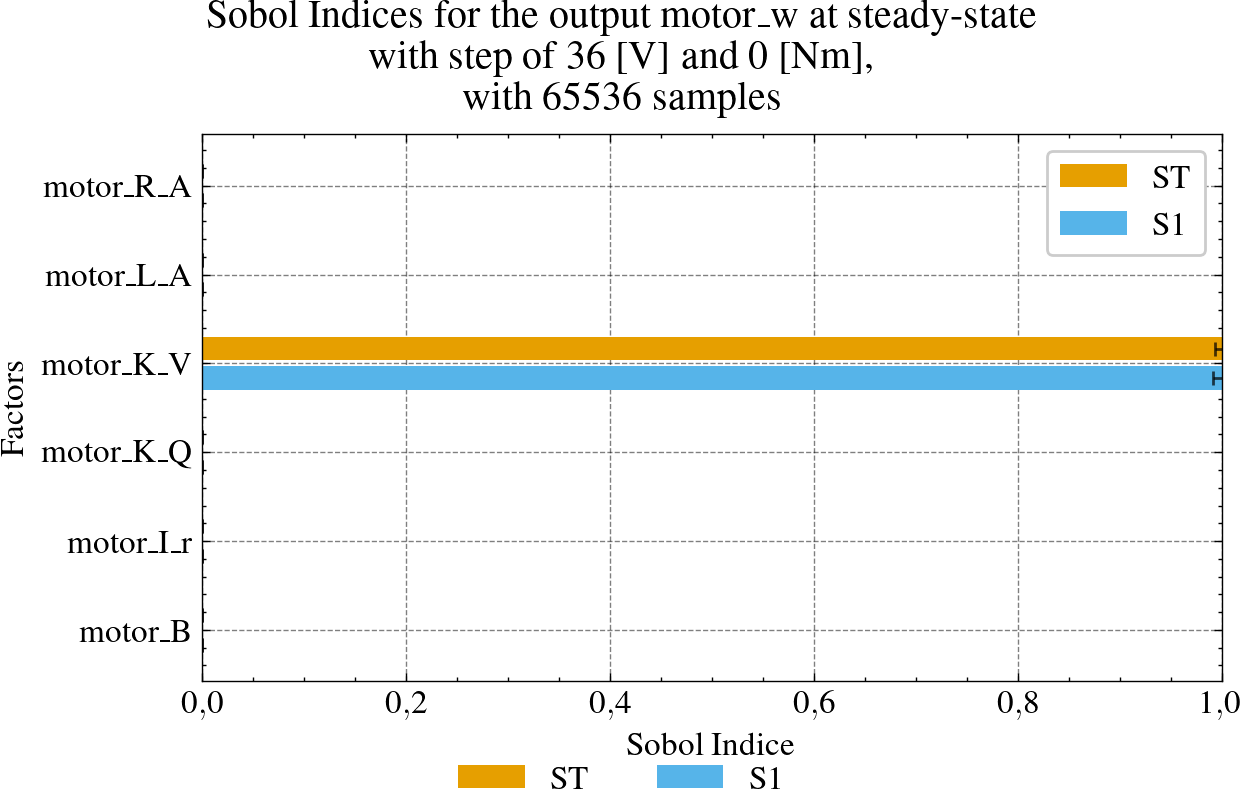

pool
chain


value          conf
output  factor    metric                            
motor_i motor_R_A S1      1.514577e-03  4.435451e-04
                  ST      1.541944e-03  1.939169e-05
        motor_L_A S1     -1.193209e-07  1.883337e-06
                  ST      3.387679e-08  1.327208e-09
        motor_K_V S1      1.634681e-01  3.686728e-03
                  ST      1.635929e-01  1.590607e-03
        motor_K_Q S1      8.336162e-01  8.562076e-03
                  ST      8.336650e-01  7.420381e-03
        motor_I_r S1     -1.061152e-06  8.150021e-05
                  ST      5.462641e-05  7.686839e-07
        motor_B   S1      1.270558e-03  4.095920e-04
                  ST      1.270512e-03  1.327291e-05
motor_w motor_R_A S1      9.153160e-03  9.536979e-04
                  ST      9.154913e-03  1.090756e-04
        motor_L_A S1     -1.365202e-08  3.277184e-07
                  ST      9.644187e-10  1.792102e-11
        motor_K_V S1      9.816390e-01  9.125160e-03
                  ST      9.816424e-01  6.524306e-03
        motor_K_Q S1      9.190370e-03  1.059127e-03
                  ST      9.192083e-03  9.564651e-05
        motor_I_r S1      5.995611e-08  8.271624e-06
                  ST      5.623451e-07  6.994345e-09
        motor_B   S1      1.399492e-05  3.876481e-05
                  ST      1.400811e-05  1.558495e-07

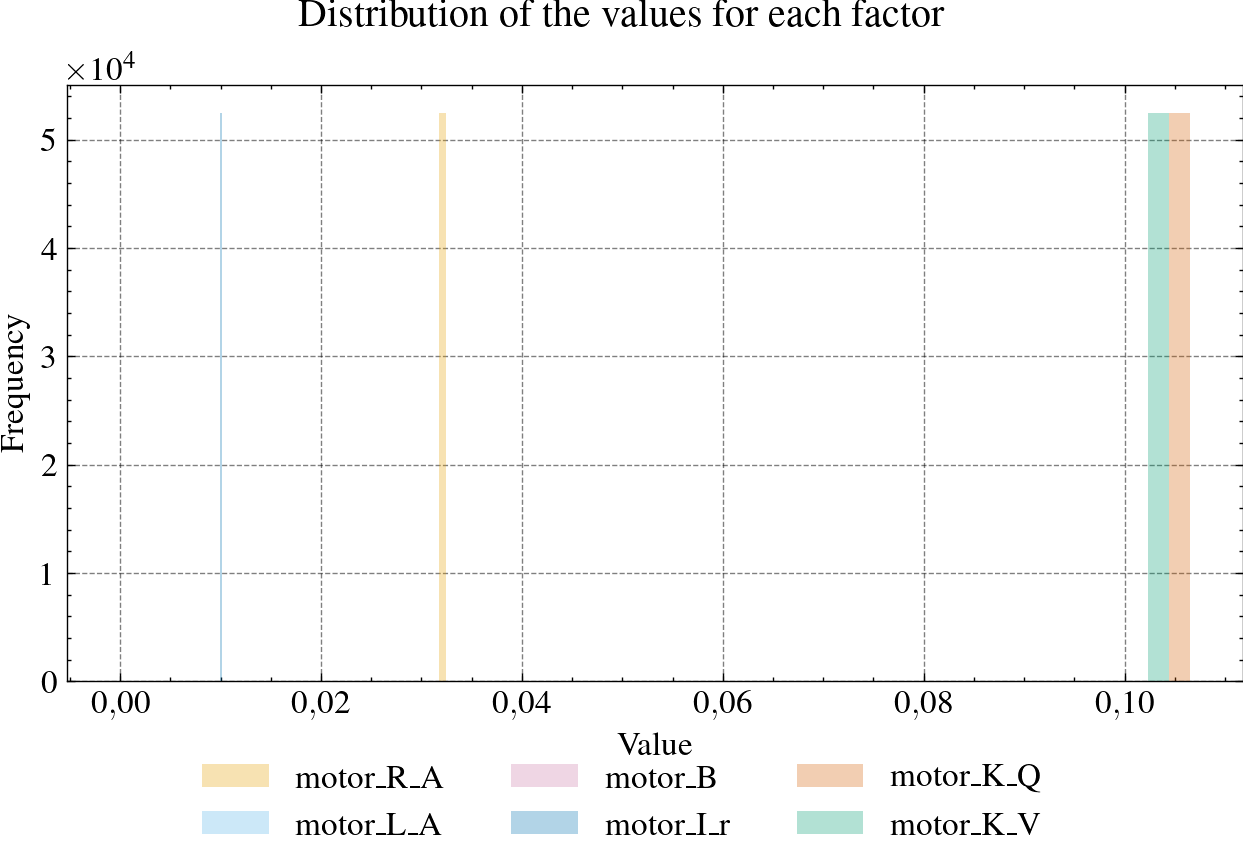

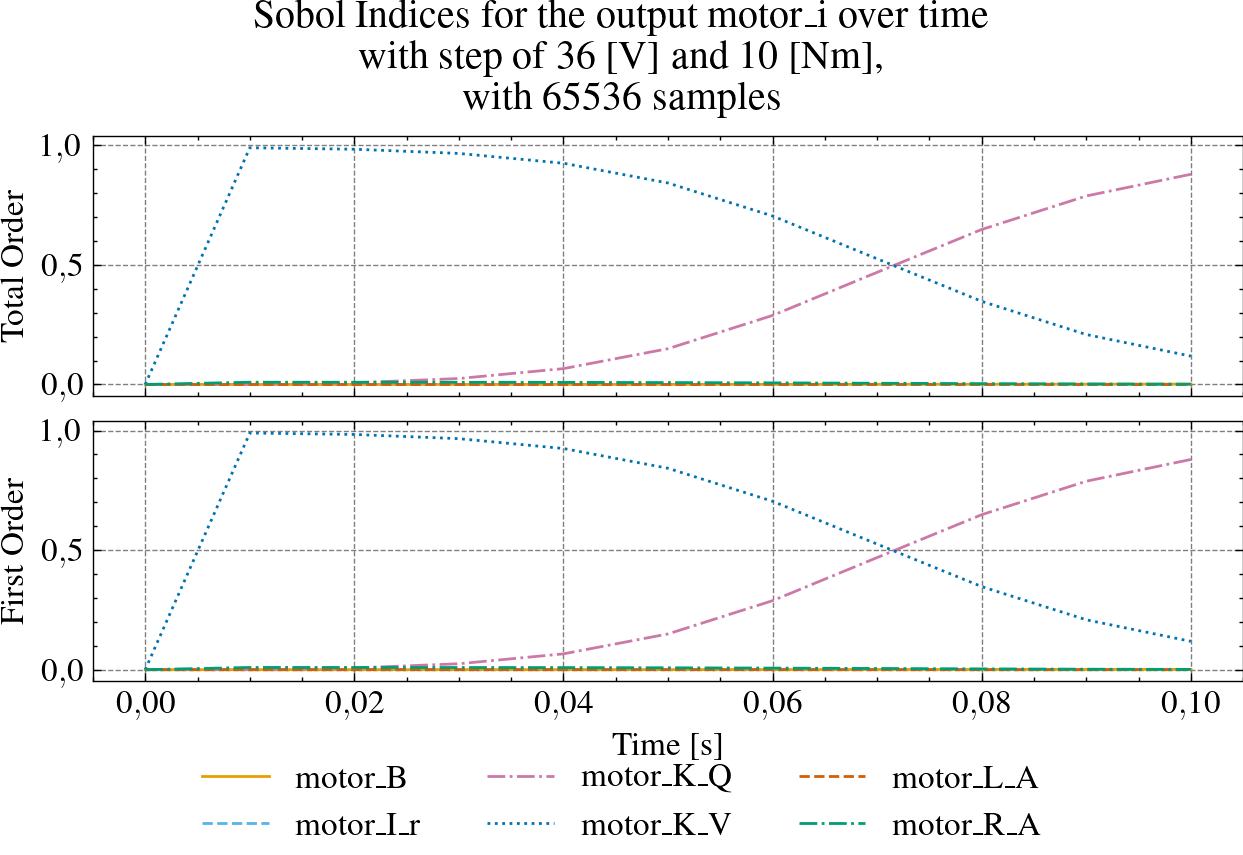

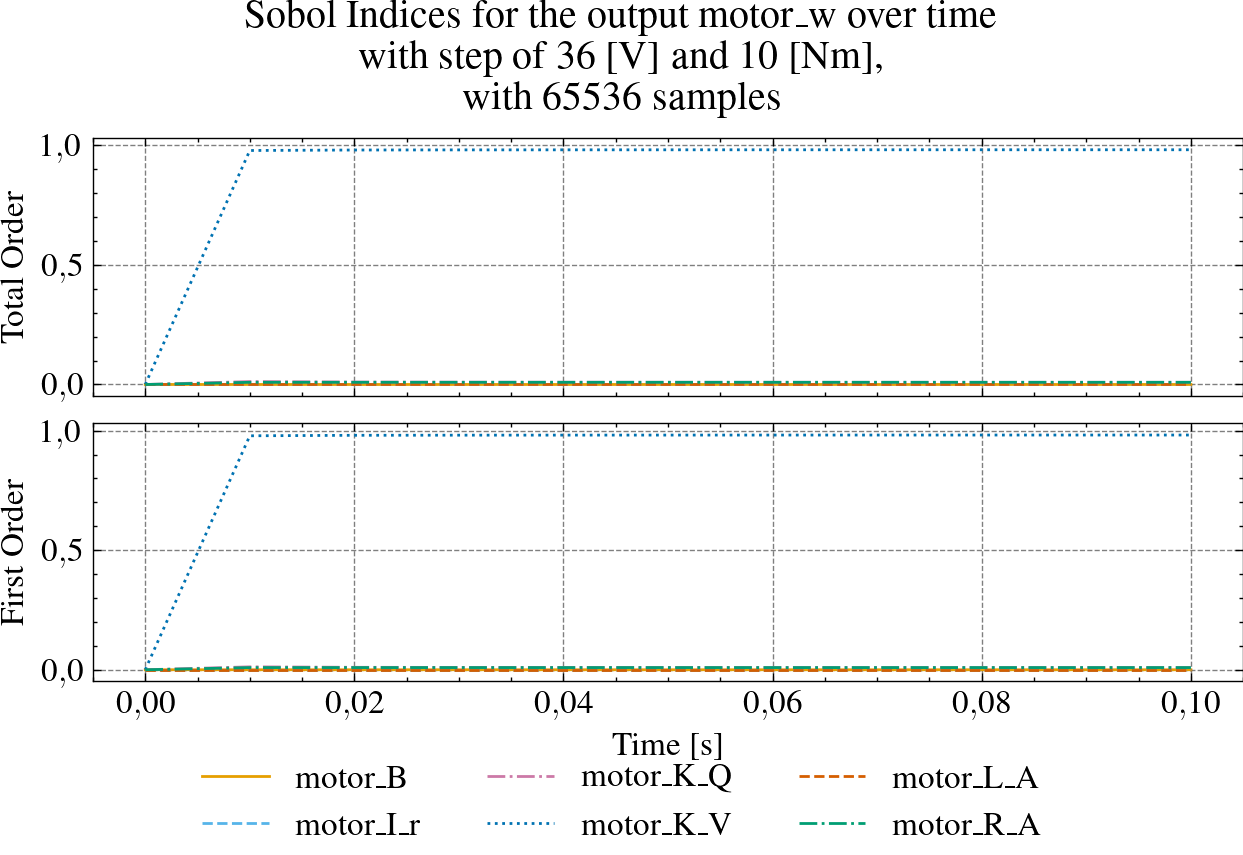

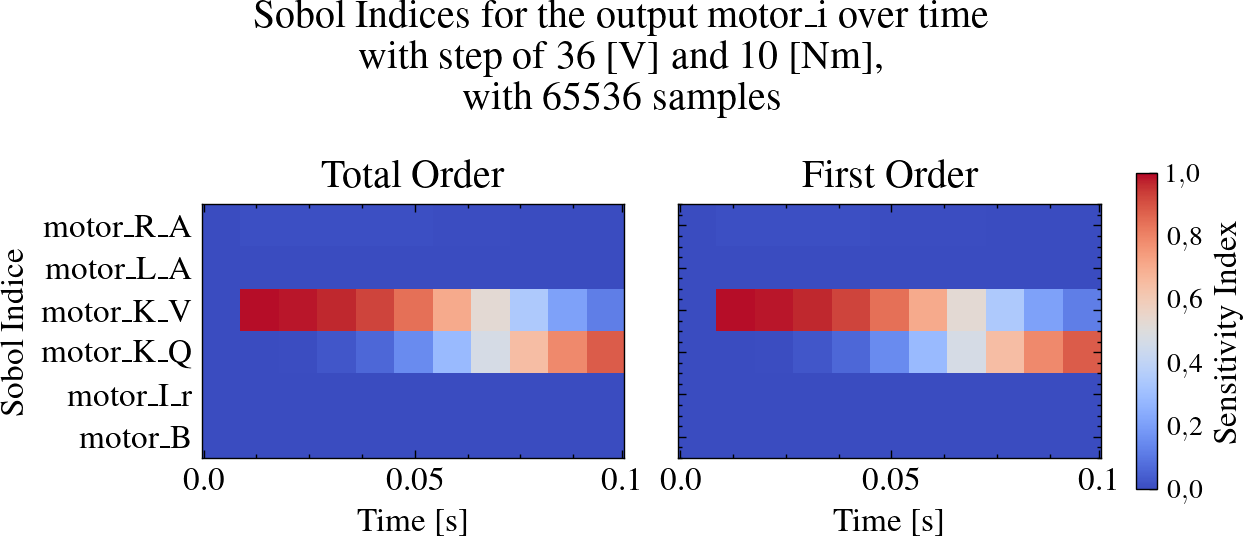

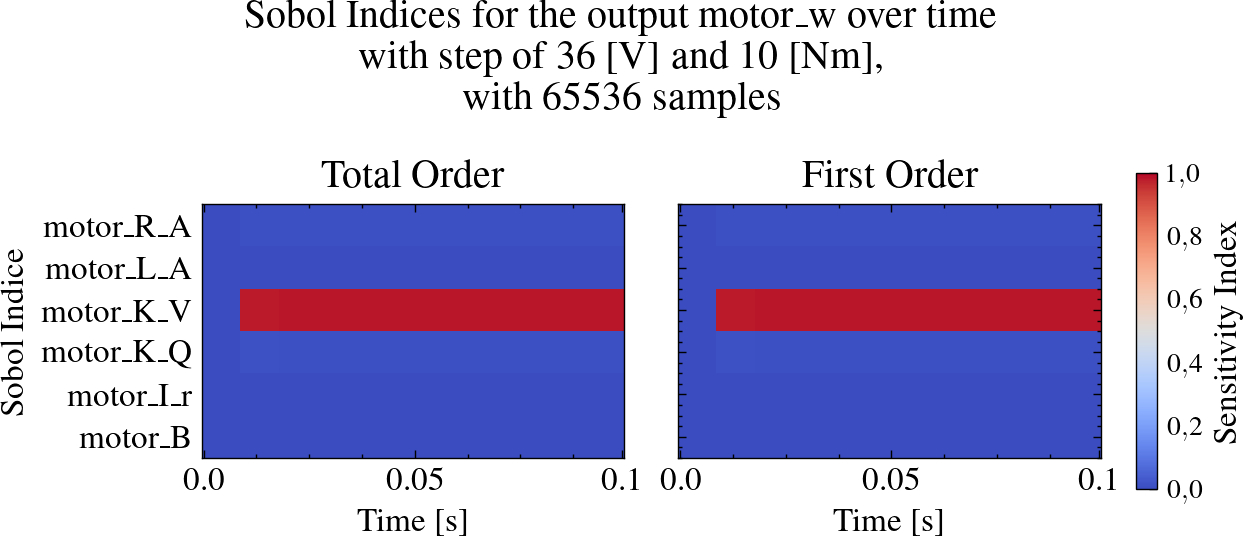

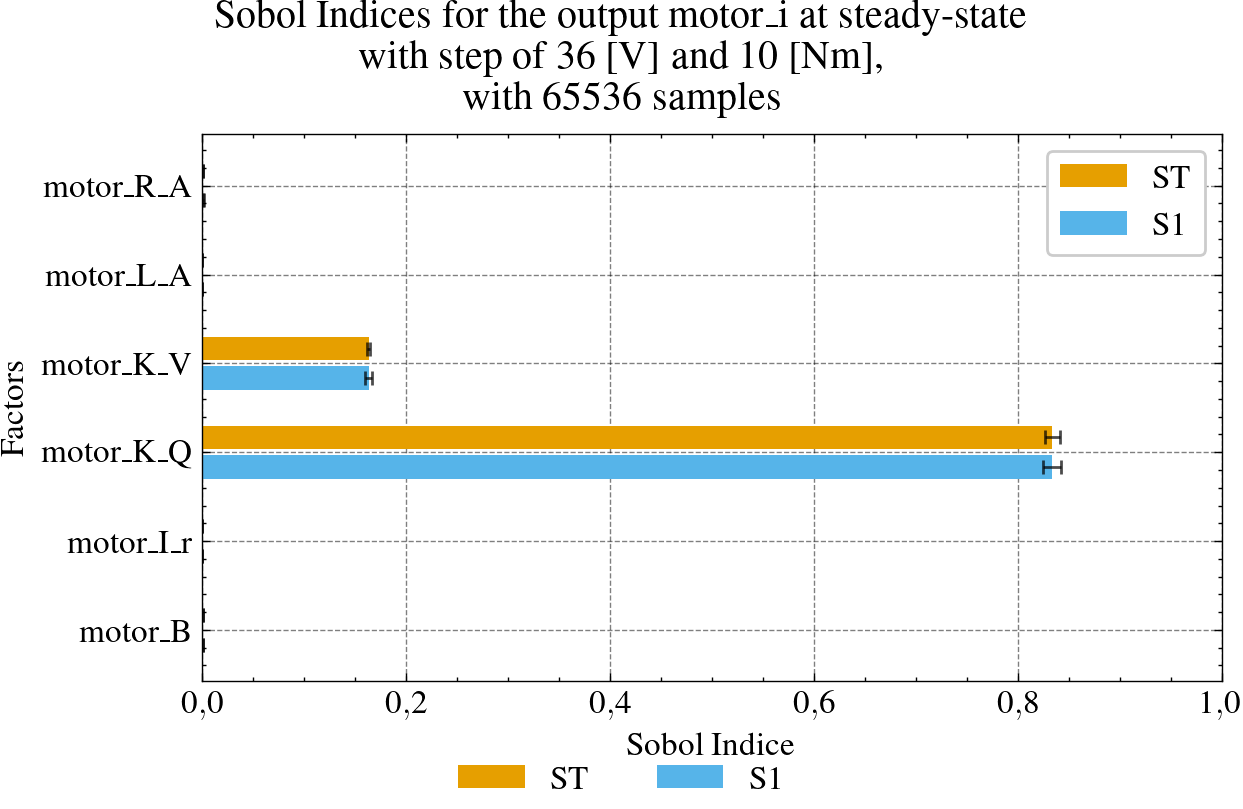

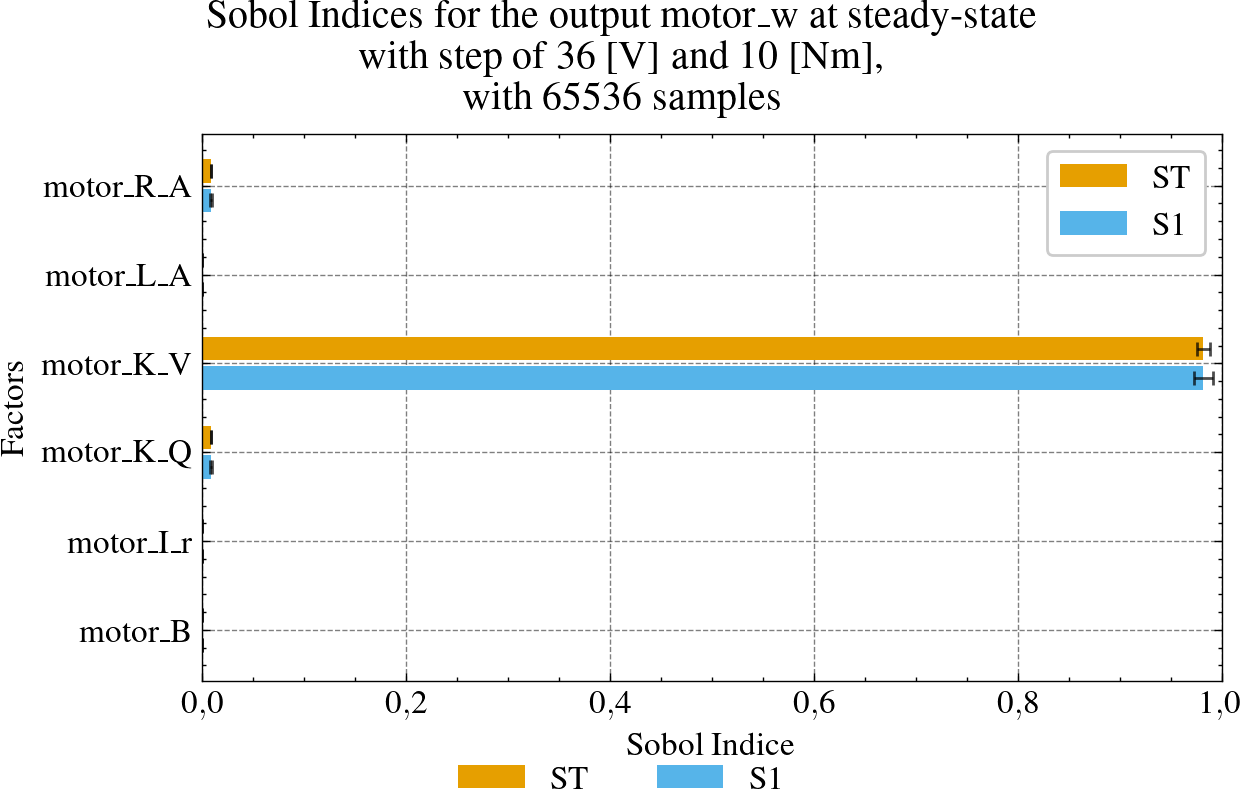

CPU times: user 8.05 s, sys: 9.7 s, total: 17.8 s
Wall time: 2min 15s


In [132]:
%%time

params_description = {
    'motor_R_A': describe_param_with_uniform_distribution(lower=motor_params['motor_R_A']*(1-u_motor_R_A), upper=motor_params['motor_R_A']*(1+u_motor_R_A)),
    'motor_L_A': describe_param_with_uniform_distribution(lower=motor_params['motor_L_A']*(1-u_motor_L_A), upper=motor_params['motor_L_A']*(1+u_motor_L_A)),
    'motor_B': describe_param_with_uniform_distribution(lower=motor_params['motor_B']*(1-u_motor_B), upper=motor_params['motor_B']*(1+u_motor_B)),
    'motor_I_r': describe_param_with_uniform_distribution(lower=motor_params['motor_I_r']*(1-u_motor_I_r), upper=motor_params['motor_I_r']*(1+u_motor_I_r)),
    # 'motor_I_r_load': describe_param_with_uniform_distribution(lower=motor_params['motor_I_r_load']*(1-u_motor_I_r_load), upper=motor_params['motor_I_r_load']*(1+u_motor_I_r_load)),
    'motor_K_Q': describe_param_with_uniform_distribution(lower=motor_params['motor_K_Q']*(1-u_motor_K_Q), upper=motor_params['motor_K_Q']*(1+u_motor_K_Q)),
    'motor_K_V': describe_param_with_uniform_distribution(lower=motor_params['motor_K_V']*(1-u_motor_K_Q), upper=motor_params['motor_K_V']*(1+u_motor_K_Q)),
}

df_sa, problem = motor_sensitivity_analysis_step_response(
    params_description=params_description,
    voltage_step=36,
    motor_load_torque_step=0,
    samples=2**16,
    do_plot=True,
)

df_sa, problem = motor_sensitivity_analysis_step_response(
    params_description=params_description,
    voltage_step=36,
    motor_load_torque_step=10,
    samples=2**16,
    do_plot=True,
)

# Optimization

In [133]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from pymoo.optimize import minimize
from pymoo.algorithms.soo.nonconvex.nelder import NelderMead
from pymoo.algorithms.soo.nonconvex.pso import PSO
from pymoo.algorithms.soo.nonconvex.isres import ISRES
from pymoo.algorithms.soo.nonconvex.es import ES
from pymoo.algorithms.soo.nonconvex.de import DE
from pymoo.algorithms.soo.nonconvex.g3pcx import G3PCX
from pymoo.algorithms.soo.nonconvex.pattern import PatternSearch
from pymoo.operators.sampling.lhs import LHS
from pymoo.termination.default import DefaultSingleObjectiveTermination
from pymoo.termination.robust import RobustTermination
from pymoo.parallelization.starmap import StarmapParallelization
from multiprocessing.pool import ThreadPool
from multiprocessing import Pool

In [134]:
motor_params = {
    # From models/2020/Motor/me0909_steady_state.ipynb - steady-state model fitted to manufacturer's dataset
    'motor_R_A': 0.03211280350781205,
    'motor_B': 0.0012793008044770459,
    'motor_K_Q': 0.10543193741528227,
    'motor_K_V': 0.10337093946599393,
    # Randomly chosen:
    'motor_L_A': 50e-06,
    'motor_I_r': 1e-2,
    'motor_I_r_load': 0,
}

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |      120 |  1.3447095322 |  0.1163950599
     2 |      240 |  0.9093561792 |  0.0849082863
     3 |      360 |  0.6555799531 |  0.0849082863
     4 |      480 |  0.5087351696 |  0.0547758074
     5 |      600 |  0.4158817216 |  0.0547758074
     6 |      720 |  0.3376256754 |  0.0482723454
     7 |      840 |  0.2693826425 |  0.0213556037
     8 |      960 |  0.2160189996 |  0.0213556037
     9 |     1080 |  0.1684843467 |  0.0125789155
    10 |     1200 |  0.1292929914 |  0.0099190134
    11 |     1320 |  0.1026558840 |  0.0099190134
    12 |     1440 |  0.0781029650 |  0.0094875184
    13 |     1560 |  0.0607471139 |  0.0060650142
    14 |     1680 |  0.0487226984 |  0.0060650142
    15 |     1800 |  0.0363243996 |  0.0037555674
    16 |     1920 |  0.0276377882 |  0.0037555674
    17 |     2040 |  0.0223266508 |  0.0025771564
    18 |     2160 |  0.0170989808 |  0.0024734673
    19 |     2280 |  0.0125163210 |  0.0020724798


{'motor_R_A': 0.03211280350781205, 'motor_L_A': 5e-05, 'motor_I_r': 0.01}

Best parameters found:


{'motor_R_A': 0.019579524515654242,
 'motor_L_A': 6.336356266841513e-05,
 'motor_I_r': 0.011828773027862982}

Objective value at solution: [0.00162468]


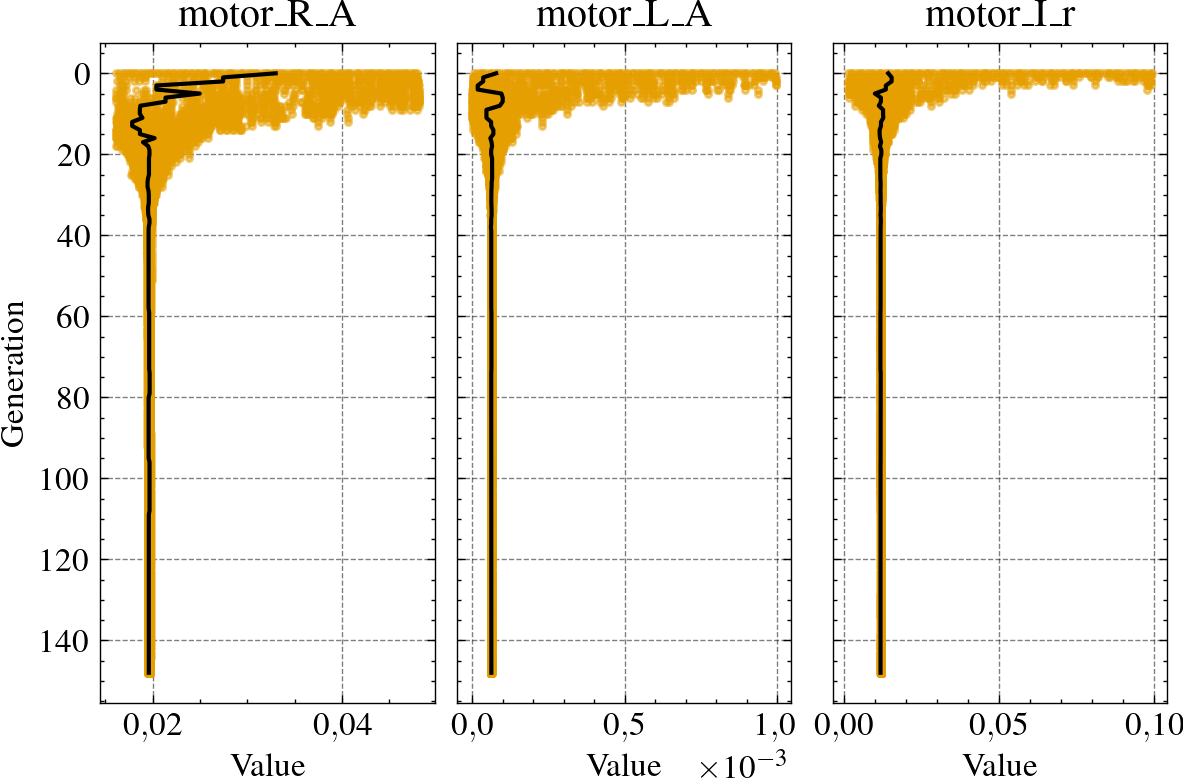

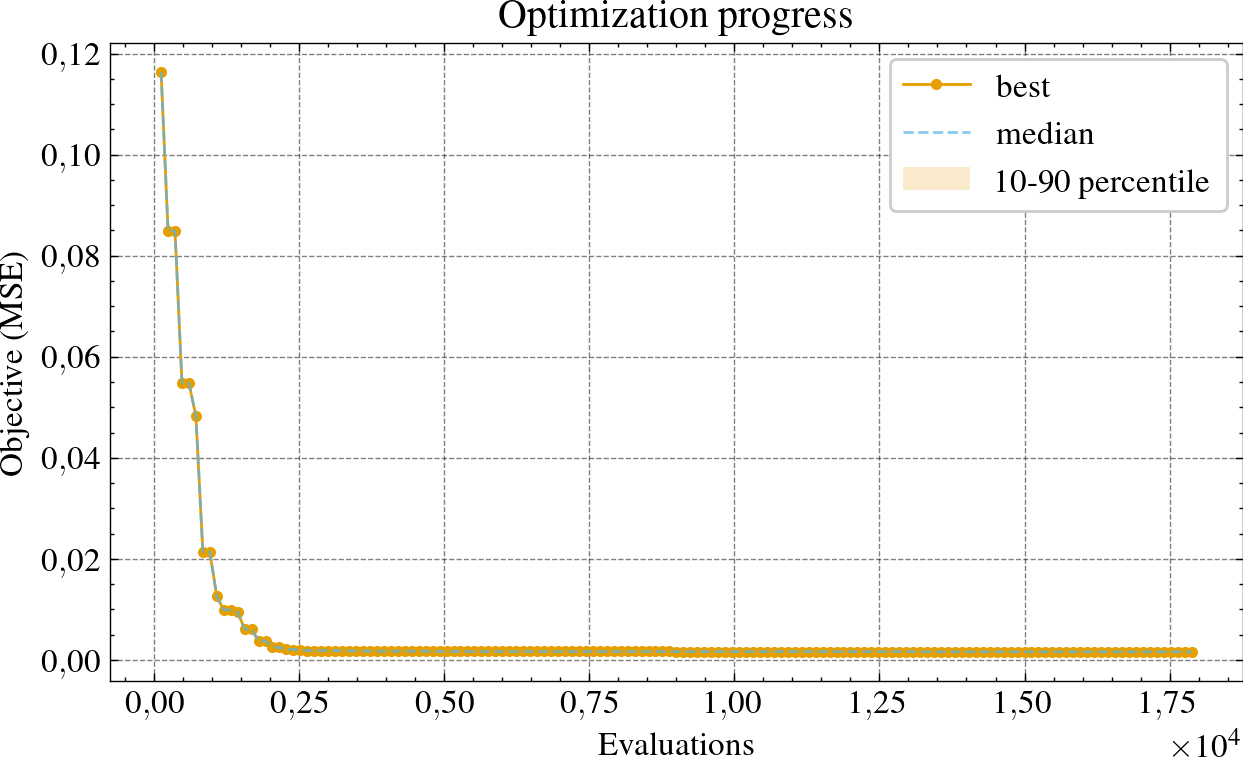

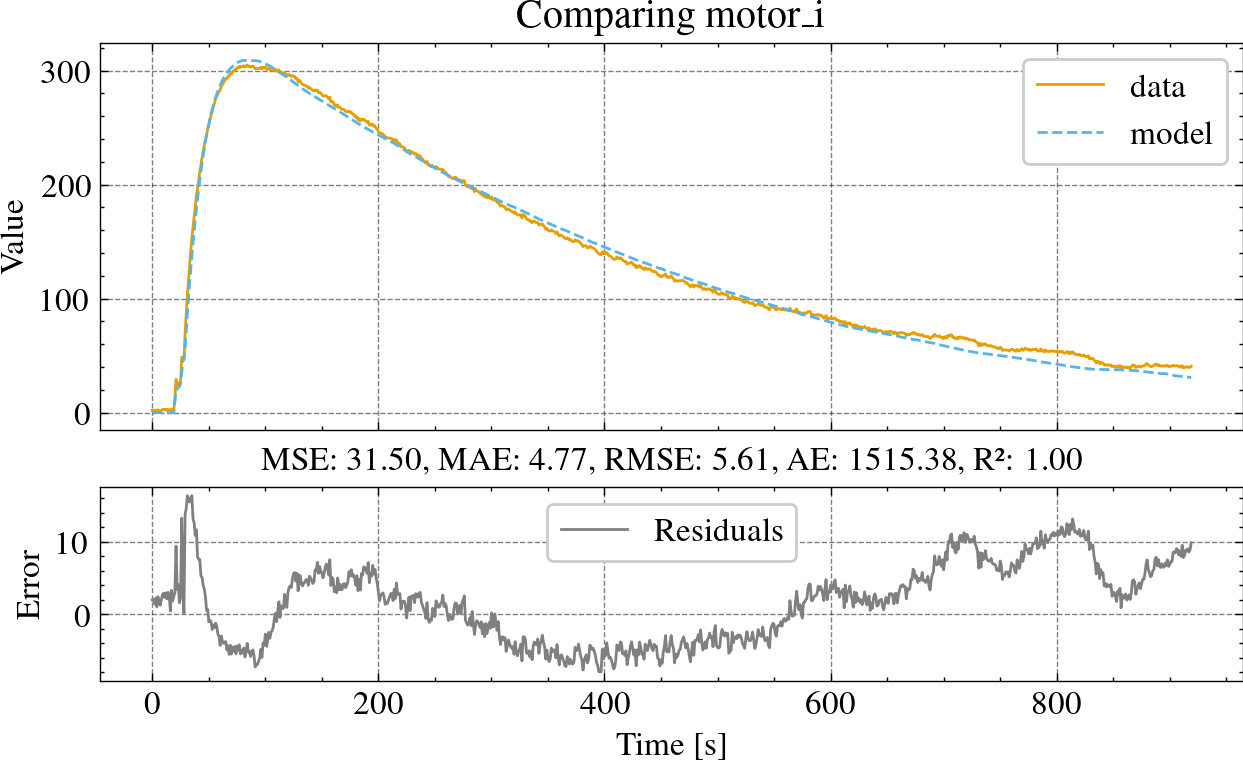

CPU times: user 7.49 s, sys: 2.94 s, total: 10.4 s
Wall time: 54.8 s


In [135]:
%%time
## MOTOR OPTIMIZATION

# Select the optimization data
data_cols = ['motor_i'] # We don't have motor_w T_T
input_cols = ['motor_v', 'motor_q_load']

# Put simulation data into df
df_train = df.copy(deep=True)[data_cols + input_cols]

# Set model states initial conditions
input_initial_state = {}

# Initialize Parameters
k = 0.5
params_bounds = {
    'motor_R_A': dict(min=(1-k)*motor_params['motor_R_A'], max=(1+k)*motor_params['motor_R_A']),
    # 'motor_B': dict(min=(1-k)*motor_params['motor_B'], max=1),
    # 'motor_K_Q': dict(min=(1-k)*motor_params['motor_K_Q'], max=(1+k)*motor_params['motor_K_Q']),
    # 'motor_K_V': dict(min=(1-k)*motor_params['motor_K_V'], max=(1+k)*motor_params['motor_K_V']),
    'motor_L_A': dict(min=1e-6, max=1e-3),
    'motor_I_r': dict(min=1e-3, max=0.1),
}

# Initialize the thread pool and create the runner
n_processes = 32
pool = Pool(processes=n_processes)
runner = StarmapParallelization(pool.starmap)
try:
    # Initialize the problem
    model = Motor
    model_params = motor_params
    problem = MyOptimizationProblem(
        model=model,
        model_function=model_function,
        training_data=df_train,
        training_data_columns=data_cols,
        model_params=model_params,
        opt_params_bounds=params_bounds,
        input_initial_state=input_initial_state,
        input_columns=input_cols,
        data_scaler=RobustScaler,
        elementwise_runner=runner,
    )

    algorithm = DE(
        pop_size=40*len(params_bounds),
        sampling=LHS(),
        variant="DE/rand/1/bin",
        # variant="DE/best/3/bin",
        F=0.5,
        CR=0.9,
    )

    # Specify termination criteria (optional)
    base_termination = DefaultSingleObjectiveTermination(
        xtol=1e-8,
        cvtol=1e-6,
        ftol=1e-6,
        period=20,
        n_max_gen=1000,
        n_max_evals=100000
    )
    termination = RobustTermination(base_termination, period=20)

    # Run the optimization
    result = minimize(
        problem,
        algorithm,
        termination=termination,
        seed=42,
        verbose=True,
        save_history=True,
    )
    print('Threads:', result.exec_time)
finally:
    pool.close()
    pool.join()

# Print the results
best_params = convert_to_model_params({k: result.X[i] for (i, k) in enumerate(params_bounds.keys())})
original_params = {k: convert_to_model_params(model_params)[k] for k in best_params.keys()}
print("Original parameters were:")
display(original_params)
print("Best parameters found:")
display(best_params)
print("Objective value at solution:", result.F)

plot_optimization_params(result, params_bounds)
plot_optimization_error(result, params_bounds)

T = np.ascontiguousarray(df['t'].to_numpy())
U = np.ascontiguousarray(df[['motor_v', 'motor_q_load']].to_numpy().T)
X0 = model.initial_state(X0=input_initial_state, U0=U[:,0], params=model_params | best_params)

best_fit_data = model_function(T, U, X0, **(model_params | best_params))

for col in data_cols:
    plot_compare(df, best_fit_data, col)


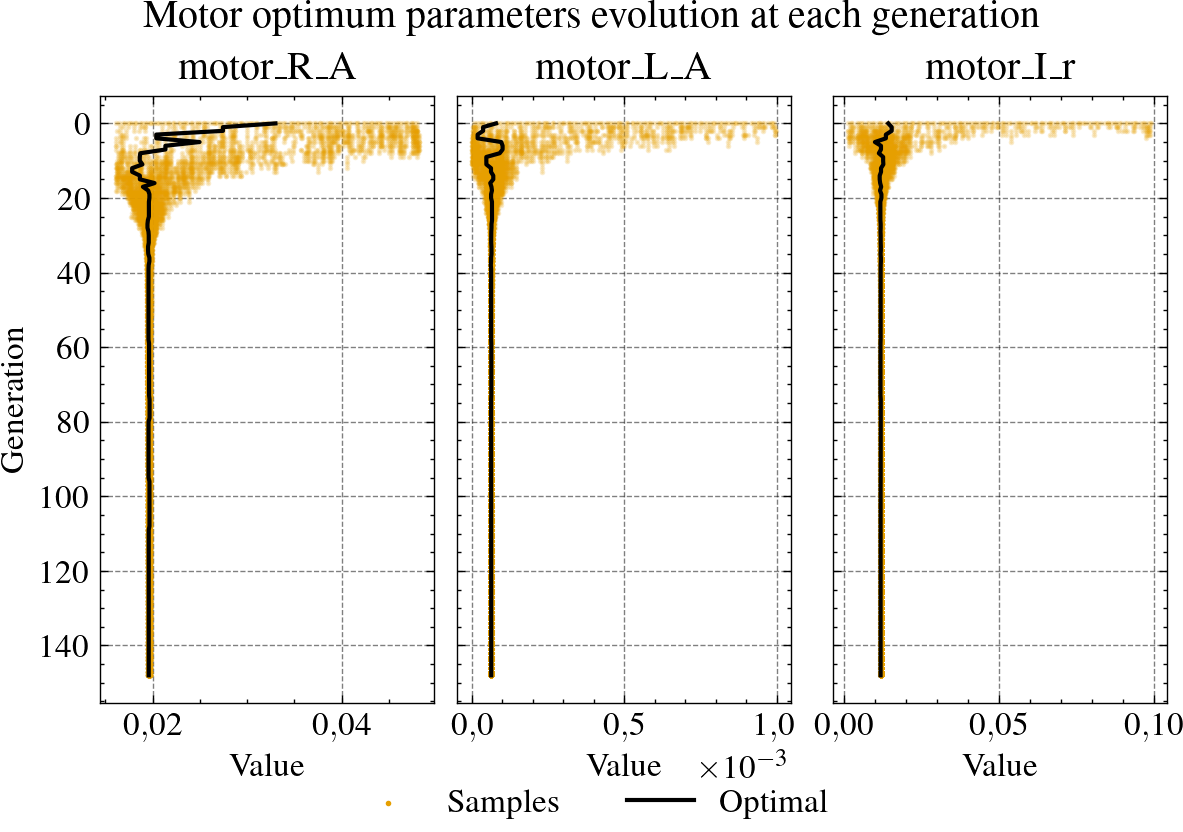

In [136]:
# Plot the original data and the fitted curve
fig_save_and_show(
    filename=f'{latex_img_path}/motor_free_rotor_optimization_params.pdf',
    show_title='Motor optimum parameters evolution at each generation',
    save_title='Evolução dos parâmetros ótimos do motor à cada geração',
    ncol=2,
    fig=plot_optimization_params(
        result,
        params_bounds=params_bounds,
        scatter_alpha=0.2,
        scatter_size=1,
        show=False
    )
)

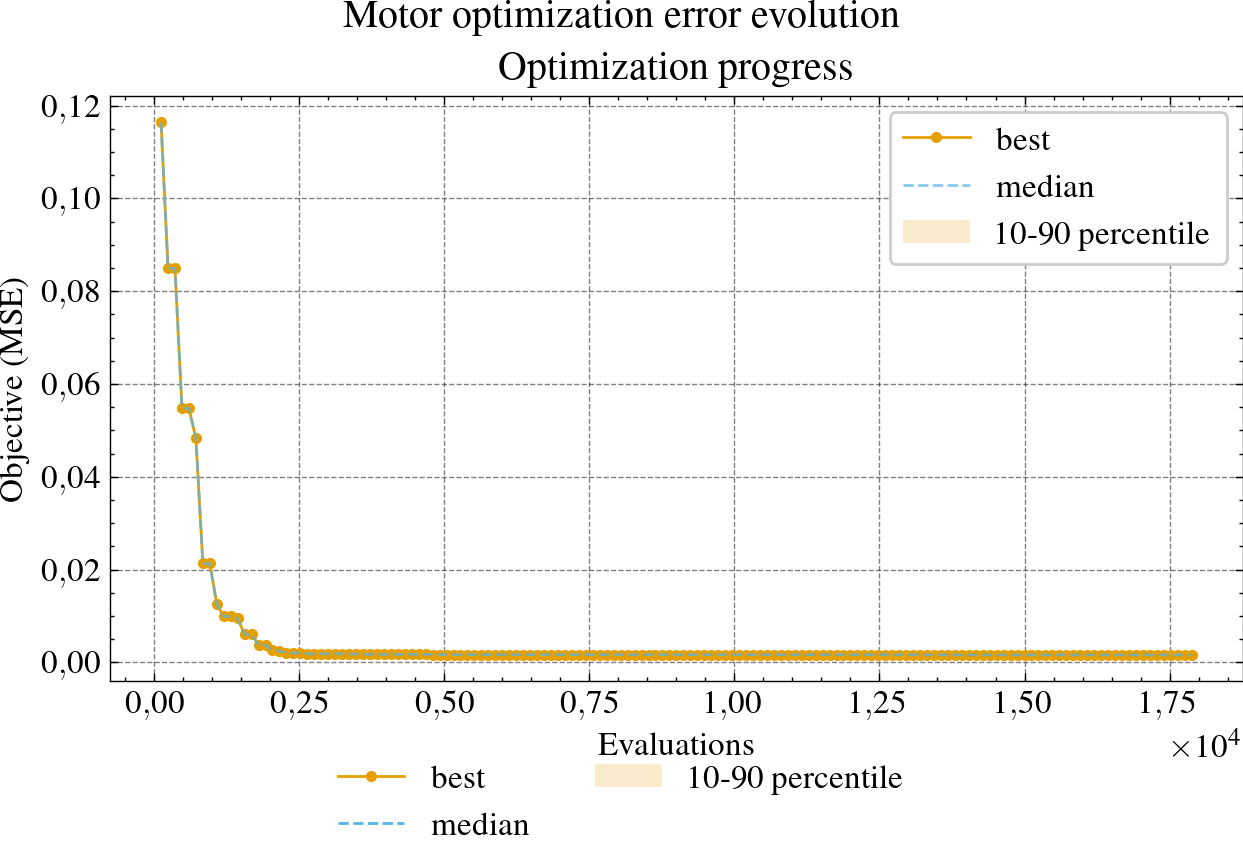

In [137]:
fig_save_and_show(
    filename=f'{latex_img_path}/motor_free_rotor_optimization_error.pdf',
    show_title='Motor optimization error evolution',
    save_title='Evolução do erro de otimização do motor',
    ncol=2,
    fig=plot_optimization_error(result, show=False),
)

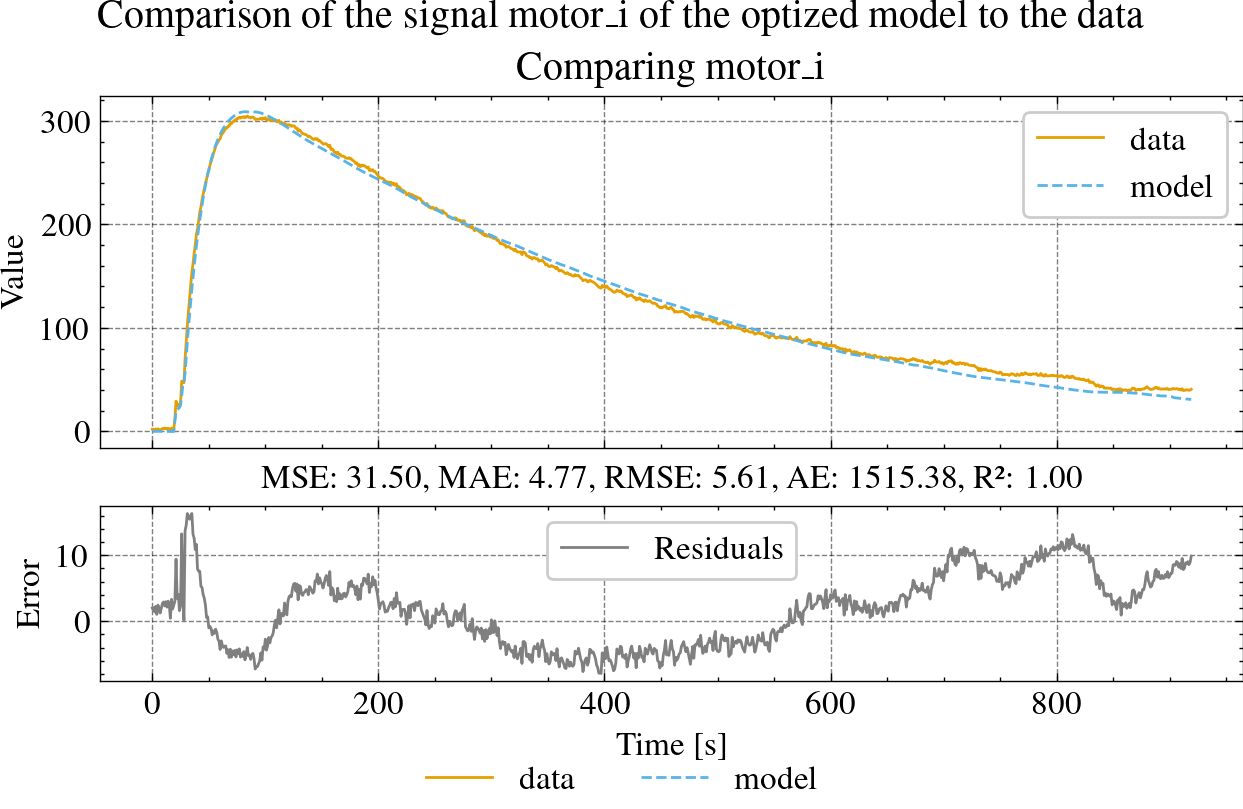

In [138]:
for col in data_cols:
    fig_save_and_show(
        filename=f'{latex_img_path}/motor_free_rotor_optimization_residuals_{col}.pdf',
        show_title=f'Comparison of the signal {col} of the optized model to the data',
        save_title=f'Comparação do sinal {col} do modelo otimizado com o dado',
        ncol=2,
        fig=plot_compare(df, best_fit_data, col, show=False),
    )

In [139]:
motor_params | best_params

{'motor_R_A': 0.019579524515654242,
 'motor_B': 0.0012793008044770459,
 'motor_K_Q': 0.10543193741528227,
 'motor_K_V': 0.10337093946599393,
 'motor_L_A': 6.336356266841513e-05,
 'motor_I_r': 0.011828773027862982,
 'motor_I_r_load': 0}

# Efficiency Map

In [ ]:
def model_function(T, U, X0, **params) -> pd.DataFrame:
    resp = ct.input_output_response(
        Motor.build(params=params),
        T=np.asarray(T, float),
        U=np.asarray(U, float),
        X0=np.asarray(X0, float),
        solve_ivp_method='Radau',
    ).to_pandas()

    motor_v = np.asarray(resp['motor_v'], float)
    motor_q_load = np.asarray(resp['motor_q_load'], float)
    motor_i = np.asarray(resp['motor_i'], float)
    motor_w = np.asarray(resp['motor_w'], float)

    motor_p_in = motor_v * motor_i
    motor_p_out = motor_w * motor_q_load

    # eps = 5.0  # W, pick something physically reasonable
    motor_eta = motor_p_out / motor_p_in
    # motor_eta[~np.isfinite(motor_eta)] = np.nan
    # # motor_eta[np.abs(motor_p_in) < eps] = np.nan     # mask low-power region
    # motor_eta[(motor_eta < 0) | (motor_eta > 1)] = np.nan  # optional physical mask
    motor_eta = np.ma.masked_invalid(motor_eta)

    resp['motor_p_in'] = motor_p_in
    resp['motor_p_out'] = motor_p_out
    resp['motor_eta'] = motor_eta

    # resp = resp.interpolate(method='linear')
    # resp = resp.fillna(method='ffill')

    return resp

Y_ss = get_steady_state_map(
    model_class=Motor,
    model_function=model_function,
    model_params=motor_params | best_params,
    sweep_bounds={
        'motor_v': dict(min=0, max=48),
        'motor_q_load': dict(min=0, max=15),
    },
    sweep_steps=100,
    dt=1,
    ss_len=2,
    ss_tail_len=1,
)

fig, ax, out = plot_efficiency_map_scattered(
    Y_ss,
    x='motor_w', y='motor_q_load', z='motor_eta',
    nx=100, ny=100,
    mask_col='motor_p_out', mask_min=0,
    level_pmin=0, level_pmax=100, level_n=100,
    contour_lines=True,
    line_pmin=0, line_pmax=95, line_n=7,
    line_colors='k',
    label_lines=1,
    title='Motor Efficiency Map',
    xlabel='Angular speed [rad/s]',
    ylabel='Torque [Nm]',
    cmap='plasma',
    fill_alpha=0.6,
)
plt.show()

TypeError: plot_efficiency_map_scattered() got an unexpected keyword argument 'fill_alpha'